In [1]:
import regression as r

In [2]:
icgem_data_gravity_ell = r.hm.load_icgem_gdf("data/south-atlantic/gravity_ell_EIGEN-6C4_5356c5f42a312695eabd65ae655e9dff12a23b3d7abf04a75ffcf294a8d022ba.gdf")
icgem_data_topography = r.hm.load_icgem_gdf("data/south-atlantic/topography_grd_etopo1-2250_4266472118e1ccb246e3435eeba94f22f0c59330cacc3a5fafbba452ed726c6d.gdf")
icgem_data_geoid = r.hm.load_icgem_gdf("data/south-atlantic/geoid_EIGEN-6C4_dad5641c3390b1ed3d9778f1575d22361bfe6e80ab465785af9ced6f09617d2b.gdf")

In [3]:
data = r.xr.merge(
    [icgem_data_gravity_ell.rename({'gravity_ell': 'gravity'}), icgem_data_topography.rename({'topography_grd': 'topography'}), icgem_data_geoid]
)

In [4]:
gamma = r.bl.WGS84.normal_gravity(data.latitude, 10000) # gravidade teórica da Terra elipsoidal

disturbance = data.gravity - gamma # medido pelo gravímetro subtraido pela teórica

topography_adjust = data.topography + data.geoid # ajustando a diferença de topografia entre geoide e elipsoide, a altura do geoide é em relação ao elipsoide

bouguer_corr = r.hm.bouguer_correction(topography_adjust)

data['dg_bouguer'] = disturbance - bouguer_corr

data

<xarray.Dataset> Size: 6MB
Dimensions:          (latitude: 346, longitude: 401)
Coordinates:
  * latitude         (latitude) float64 3kB -57.0 -56.8 -56.6 ... 11.6 11.8 12.0
  * longitude        (longitude) float64 3kB -57.0 -56.8 -56.6 ... 22.8 23.0
Data variables:
    gravity          (latitude, longitude) float64 1MB 9.786e+05 ... 9.752e+05
    height_over_ell  (latitude, longitude) float64 1MB 1e+04 1e+04 ... 1e+04
    topography       (latitude, longitude) float64 1MB -4.207e+03 ... 651.0
    geoid            (latitude, longitude) float64 1MB 19.83 19.82 ... 4.775
    dg_bouguer       (latitude, longitude) float64 1MB 320.2 277.7 ... -70.66
Attributes: (12/35)
    generating_institute:  gfz-potsdam
    generating_date:       2026/02/05
    product_type:          gravity_field
    body:                  earth
    modelname:             EIGEN-6C4
    max_used_degree:       250
    ...                    ...
    maxvalue:              9.7864506E+05 mgal
    minvalue:              9.7490335E+05 mgal
    signal_wrms:           1.0805756E+03 mgal
    grid_format:           long_lat_value
    attributes:            longitude latitude gravity_ell
    attributes_units:      deg. deg. mgal

In [5]:
topo_raw = data.topography.values.ravel()
dg_raw = data.dg_bouguer.values.ravel()
    
region = r.vd.get_region((data.longitude.values, data.latitude.values))
lon_grid, lat_grid = r.vd.grid_coordinates(region=region, shape=data.topography.shape, meshgrid=True)
lon_raw, lat_raw = lon_grid.ravel(), lat_grid.ravel()

mask = ~r.np.isnan(topo_raw) & ~r.np.isnan(dg_raw)
h, d = topo_raw[mask], dg_raw[mask]
lon, lat = lon_raw[mask], lat_raw[mask]

In [6]:
df_windows, indices = r.windows_regression(data, h, d, lon, lat, window_size=4.0, overlap=0.5, min_points = 4)
df_windows.to_csv('df_windows.csv')

df_windows_mixed_coefs = df_windows.dropna(subset = ['a_o', 'a_c', 'b'])
df_windows_mixed_coefs.to_csv('df_windows_mixed_coefs.csv')

df_windows_ocean = df_windows[df_windows['a_c'].isna()]
df_windows_ocean.to_csv('df_windows_ocean.csv')

df_windows_continent = df_windows[df_windows['a_o'].isna()]
df_windows_continent.to_csv('df_windows_continent.csv')

df_fodase = df_windows[df_windows['r2'] < 0.7]
df_fodase.to_csv('df_fodase.csv')

print(f' \nMédia de pontos no oceano por janela: {r.np.mean(df_windows.ocean_points)}')
print(f'Média de pontos no continente por janela: {r.np.mean(df_windows.continent_points)}\n')


v_o = 0.06
print(f'\nJanelas de oceano com coeficiente maiores que |{v_o}|: {len(df_windows.a_o[(df_windows.a_o < -v_o) | (df_windows.a_o > v_o)])}')

v_c = 1
print(f'Janelas de continente com coeficiente maiores que |{v_c}|: {len(df_windows.a_c[(df_windows.a_c < -v_c) | (df_windows.a_c > v_c)])}')

v_r = 0.6
print(f'Janelas com r2 < {v_r}: {len(df_windows[df_windows.r2 < v_r])}\n')


#df_windows[(df_windows.a_o < -v_o) | (df_windows.a_o > v_o)]
#df_windows[(df_windows.a_c < -v_c) | (df_windows.a_c > v_c)]

df_windows_continent[df_windows_continent.r2 < v_r]



 0 janelas foram ignoradas por falta de dados.
 
Média de pontos no oceano por janela: 370.671146953405
Média de pontos no continente por janela: 93.71774193548387


Janelas de oceano com coeficiente maiores que |0.06|: 862
Janelas de continente com coeficiente maiores que |1|: 0
Janelas com r2 < 0.6: 41



,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
575,20.891784,-18.43750,NaN,-0.049160,-62.557127,0.479192,575,440,0,440
651,-54.952671,-12.34375,NaN,-0.089183,-21.024350,0.375913,651,420,0,420
653,-50.849680,-12.34375,NaN,-0.051463,-32.039396,0.335857,653,400,0,400
691,-50.862604,-10.31250,NaN,-0.031226,-38.829390,0.156950,691,400,0,400
727,-54.978926,-8.28125,NaN,-0.089176,-24.758781,0.583399,727,400,0,400
728,-52.980035,-8.28125,NaN,-0.089051,-24.121232,0.533248,728,420,0,420
729,-50.981145,-8.28125,NaN,-0.058011,-31.707252,0.433347,729,420,0,420
730,-48.982254,-8.28125,NaN,-0.074229,-32.759218,0.481335,730,420,0,420
732,-44.984472,-8.28125,NaN,-0.076258,-35.943607,0.575522,732,420,0,420
766,-54.988042,-6.25000,NaN,-0.075292,-33.419793,0.424642,766,400,0,400


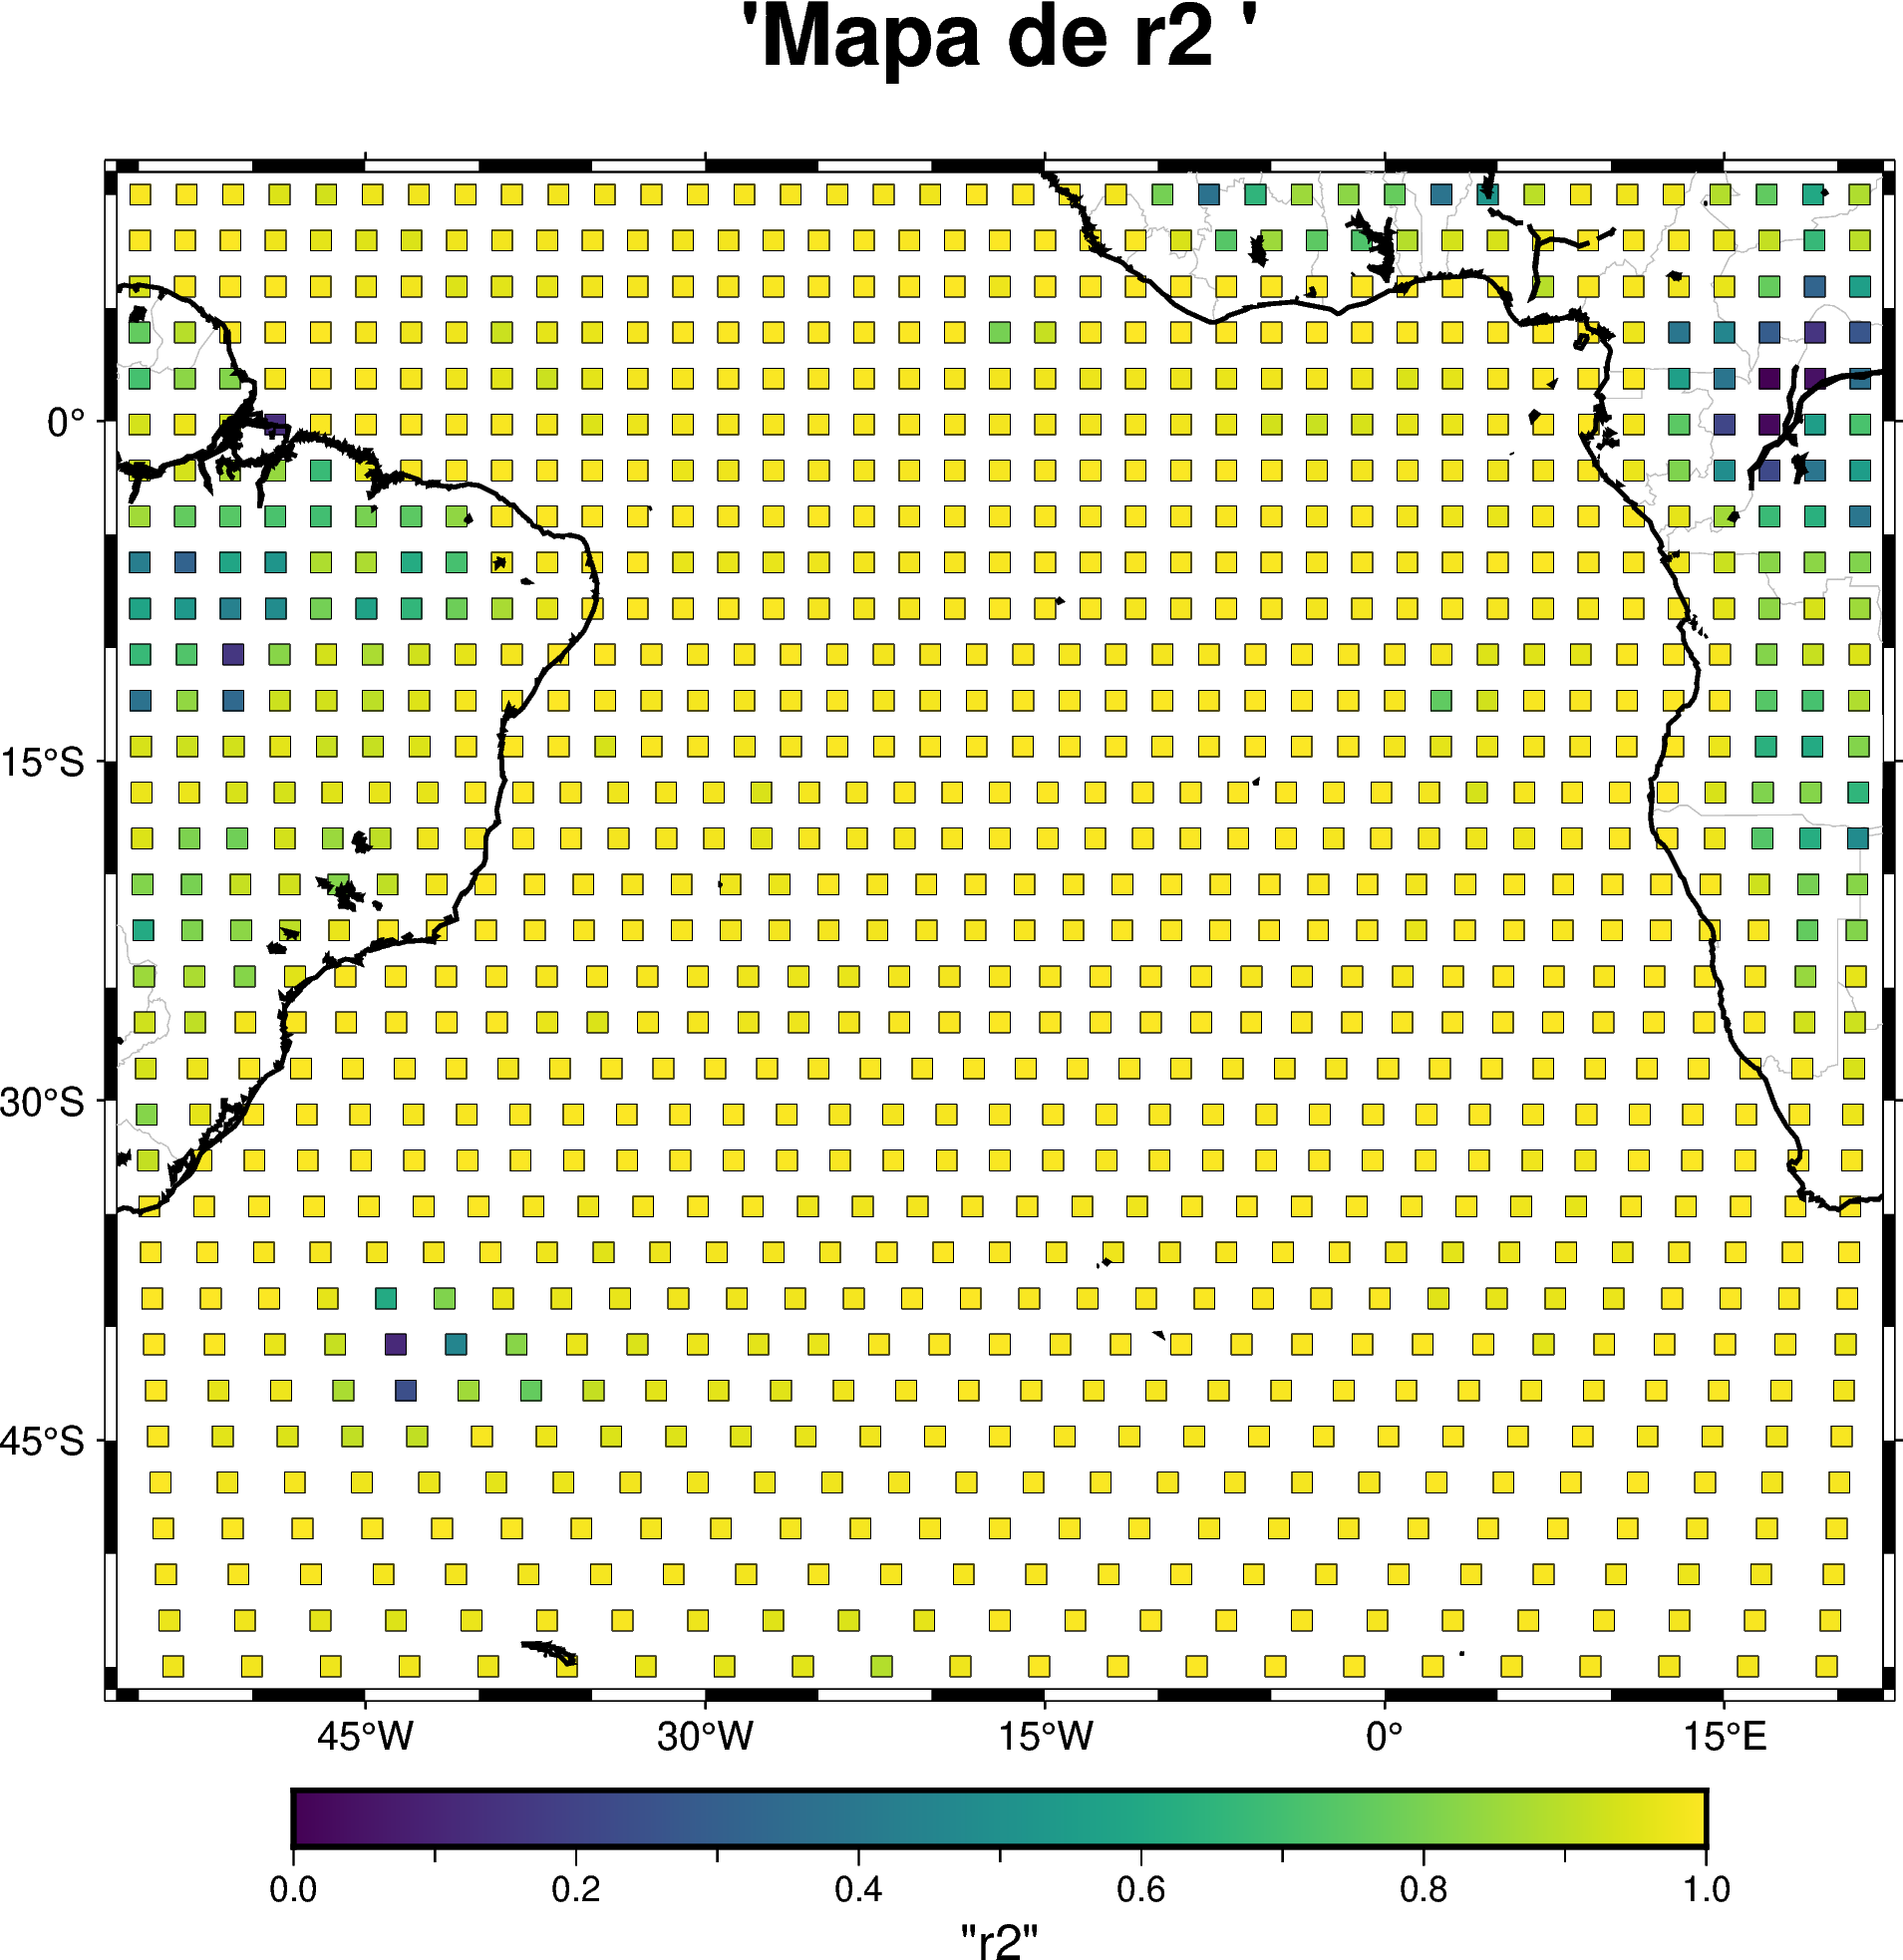

In [7]:
fig_r2 = r.plot_parameters_map(df_windows, 'r2', v_range = [0, 1], step = 0.01, cmap='viridis', reverse=False, projection = 'Q')
fig_r2.coast(shorelines='1p,black')
fig_r2.savefig('mapa-r2.png')

fig_a_o = r.plot_parameters_map(df_windows, 'a_o', v_range = [-1, 1], step = 0.01, cmap = 'polar', reverse = False, projection = 'Q')
fig_a_o.coast(shorelines = '0.5p,black')
fig_a_o.savefig('mapa-a_o.png')

fig_a_c = r.plot_parameters_map(df_windows, 'a_c', v_range = [-2, 2], step = 0.01, cmap = 'polar', reverse = False, projection = 'Q')
fig_a_c.coast(shorelines = '0.5p,black')
fig_a_c.savefig('mapa-a_c.png')


fig_r2.show()

# Acessando a janela mais próxima dadas as coordenadas

In [8]:
# achando janela mais próxima a um ponto dada a coordenada 
lon_window = 15
lat_window = 0


distances = r.np.sqrt((df_windows['longitude'] - lon_window)**2 + (df_windows['latitude'] - lat_window)**2)

distances

window_minor_distance = distances.idxmin()
line_in_df_minor_distance = df_windows.loc[df_windows['original-idx'] == window_minor_distance]

line_in_df_minor_distance


,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
918,14.999994,-0.15625,NaN,-0.04838,-37.729505,0.207437,918,420,0,420


In [9]:
idx_current = indices[window_minor_distance][0]
idx_current

h_window_raw = h[idx_current]
d_window_raw = d[idx_current]

idx_sort = r.np.argsort(h_window_raw)
h_window = h_window_raw[idx_sort]
d_window = d_window_raw[idx_sort]

p_window = r.robust_regression(h_window, d_window, min_points = 5)
a_ocean_window, a_continent_window, intercept_window, r2_window = p_window

p_window

(nan,
 np.float64(-0.04838028473262404),
 np.float64(-37.7295045395112),
 np.float64(0.2074372827705968))

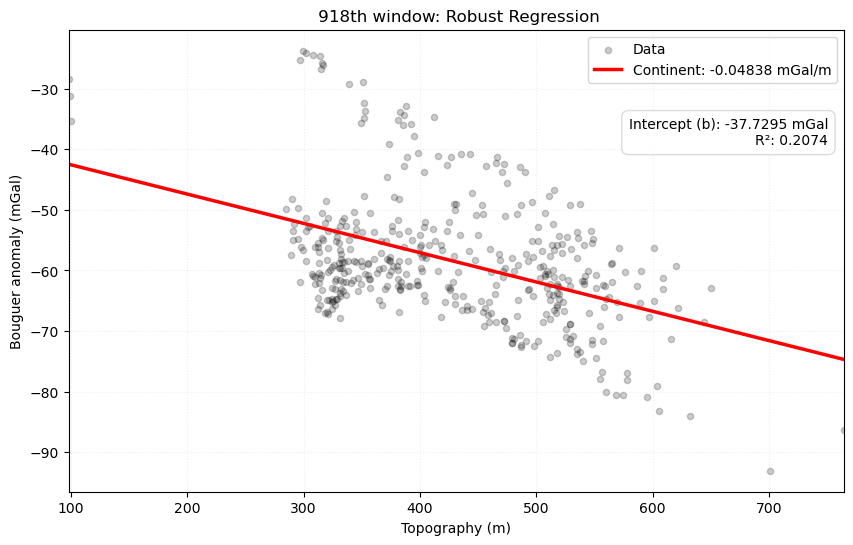

In [10]:
r.plot_window_regression(window_minor_distance, h_window, d_window, a_ocean_window, a_continent_window, intercept_window, r2_window)

O círculo rosa é a localização da janela.



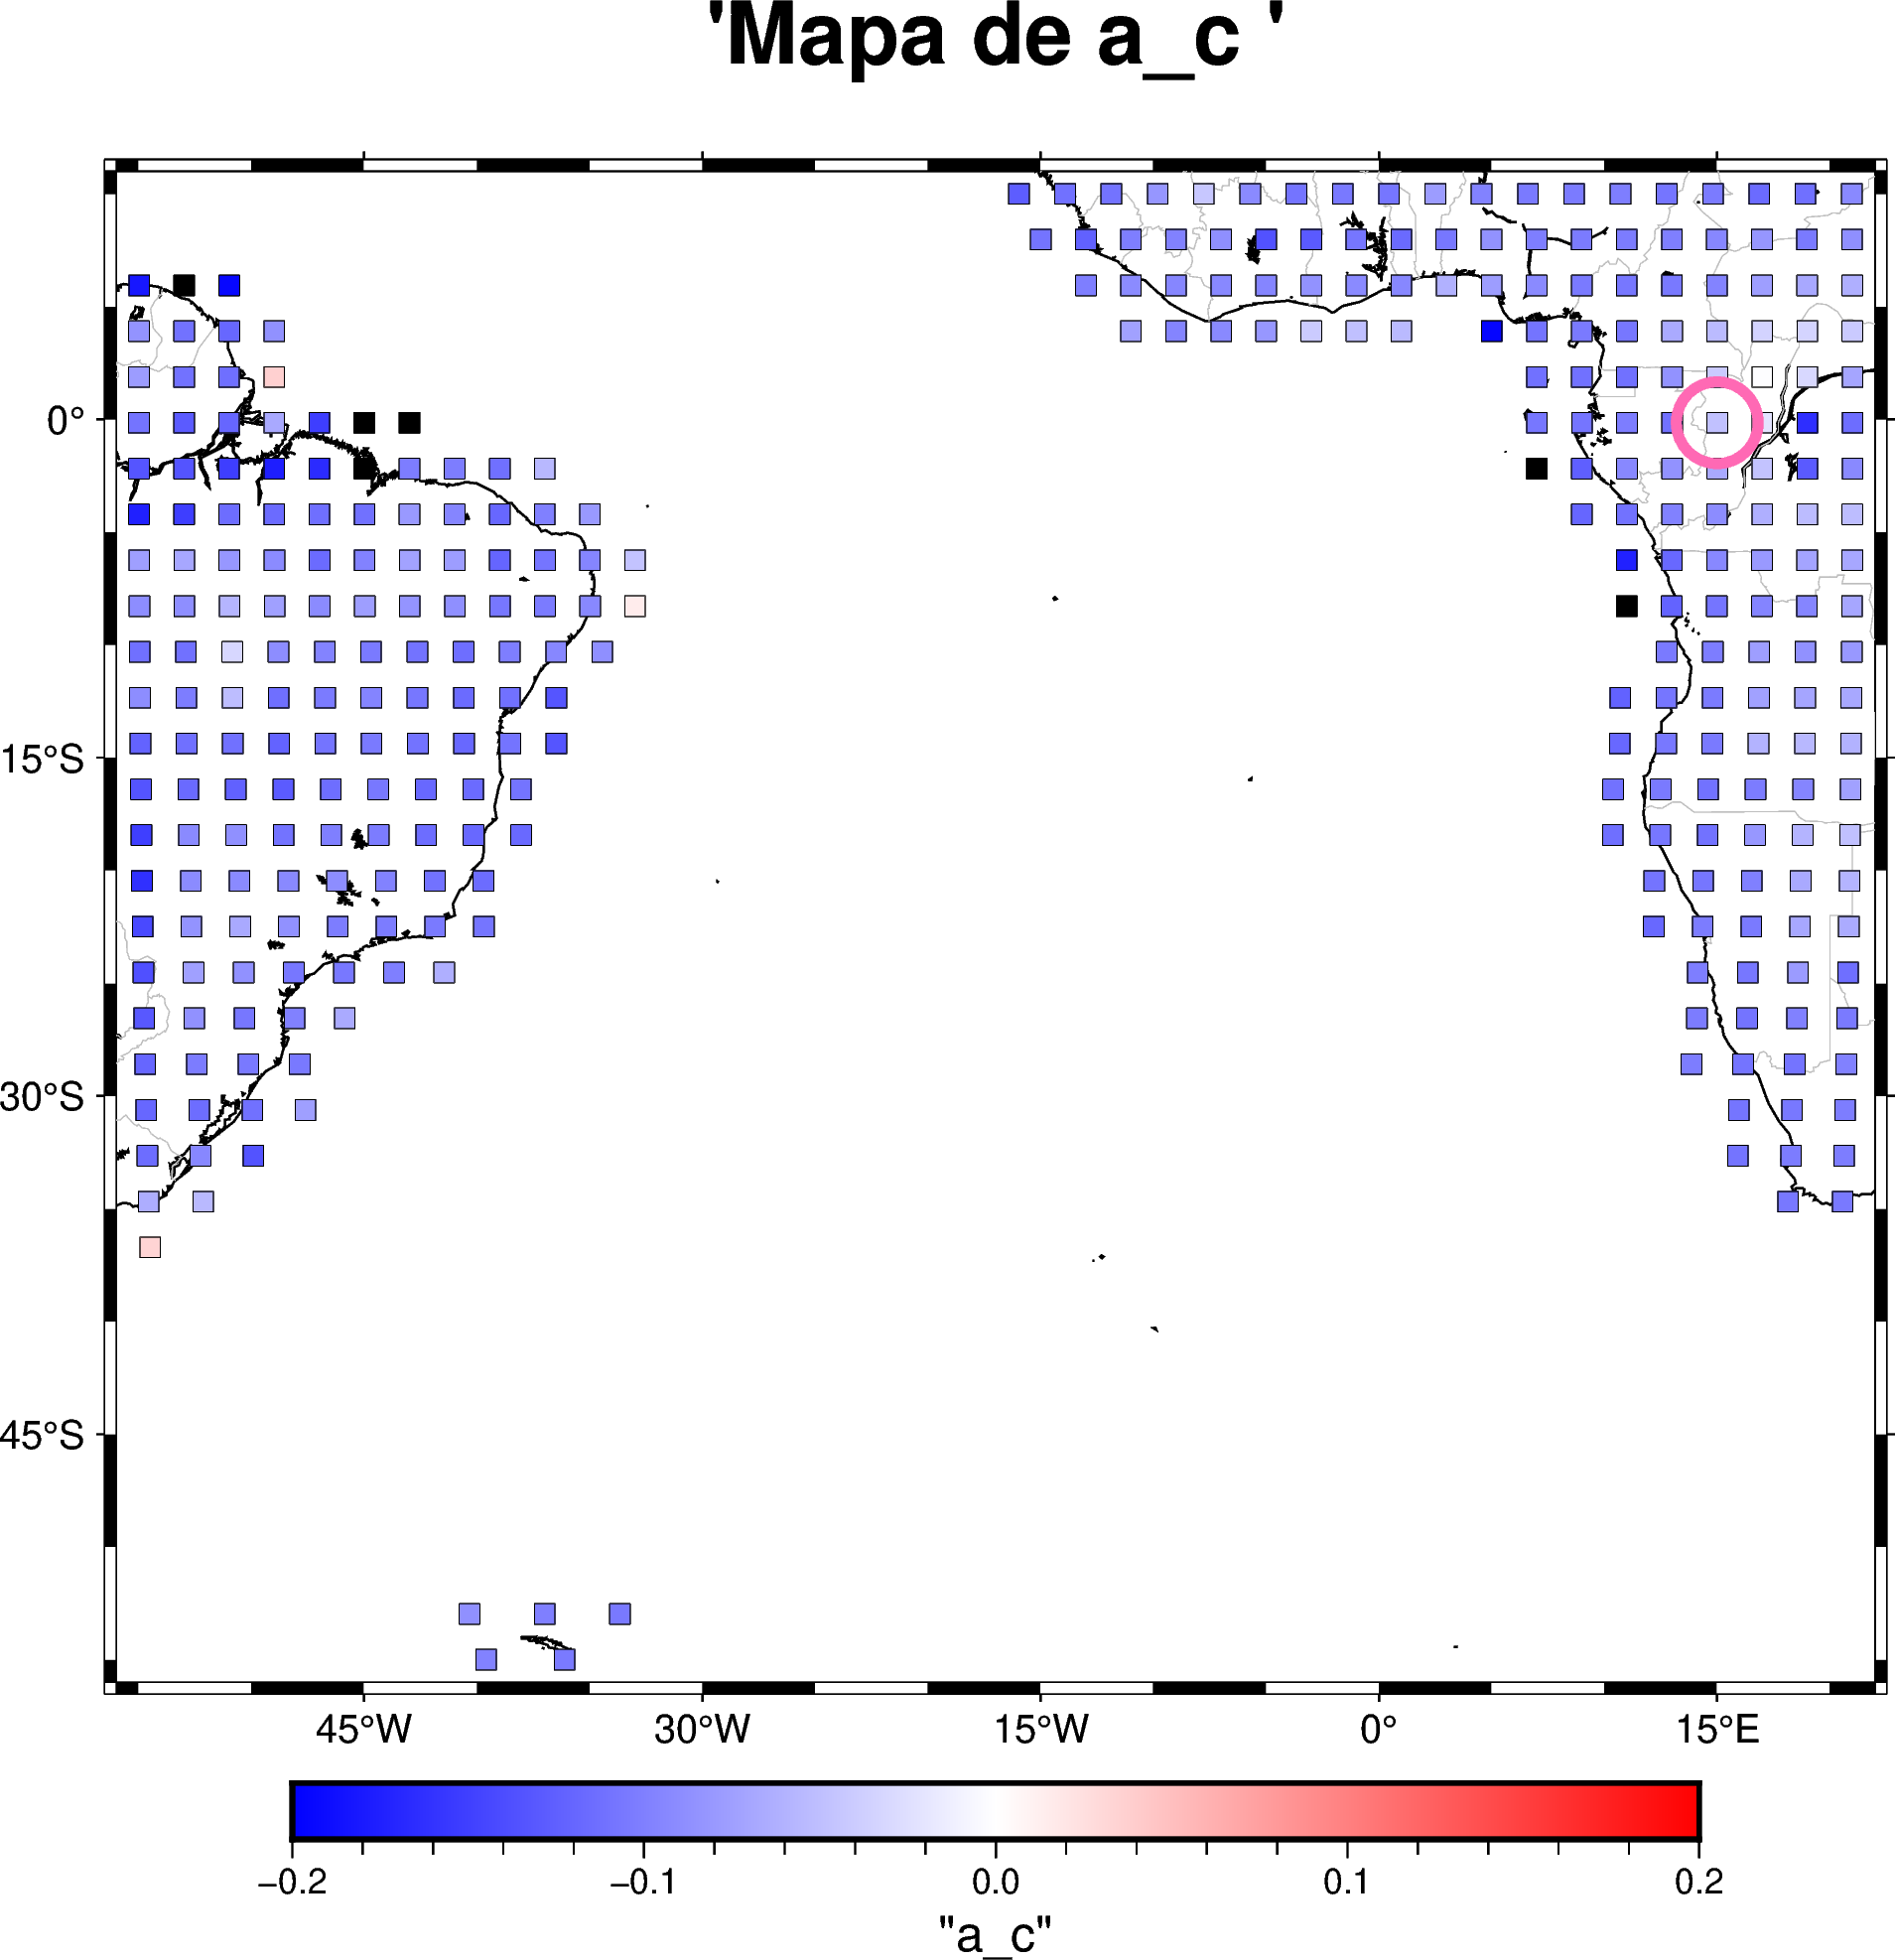

In [11]:
lon_alvo = df_windows.loc[window_minor_distance, 'longitude']
lat_alvo = df_windows.loc[window_minor_distance, 'latitude']

# 2. Gerar o mapa base (ele retorna o objeto 'fig')
fig = r.plot_parameters_map(df_windows, 'a_c', v_range=[-0.2, 0.2], step=0.01, cmap='polar', reverse=False, projection = 'Q')

# 3. Desenhar um círculo de destaque sobre o mapa
# Criamos um "efeito de borda" com dois círculos sobrepostos
fig.plot(
    x=lon_alvo, 
    y=lat_alvo, 
    style='c0.7c', 
    pen='2.5p,hotpink' 
)

print('O círculo rosa é a localização da janela.')
print()
fig.show()

# Acessando janela específica

In [12]:
# janela especifica que quero acessar
i_wished_window = 428
line_in_df = df_windows.loc[df_windows['original-idx'] == i_wished_window] # localizo original-idx

if not line_in_df.empty: # para caso a linha não esteja no df 
    lon = line_in_df['longitude'].values[0] # [0] para o pandas não bugar, ele ve values como filtro
    lat = line_in_df['latitude'].values[0]

    print(f'A janela {i_wished_window} tem coordenadas: Longitude {lon:.2f} e Latitude {lat:.2f}')

else:
    print(f'A janela não está no df e pode ter sido descartada ou está vazia')

line_in_df

A janela 428 tem coordenadas: Longitude 14.10 e Latitude -26.56


,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
428,14.09975,-26.5625,-0.063397,-0.102325,28.426421,0.999525,428,440,328,112


In [13]:
idx_current = indices[i_wished_window][0]

h_window_raw = h[idx_current]
d_window_raw = d[idx_current]

# crio uma lista com os índices de h_window_raw que colocam o array em ordem numérica ex: [28, 3, 87] é o que deicaria o array em ordem
idx_sort = r.np.argsort(h_window_raw)
h_window = h_window_raw[idx_sort]
d_window = d_window_raw[idx_sort]

p_window = r.robust_regression(h_window, d_window, min_points = 5)
a_ocean_window, a_continent_window, intercept_window, r2_window = p_window

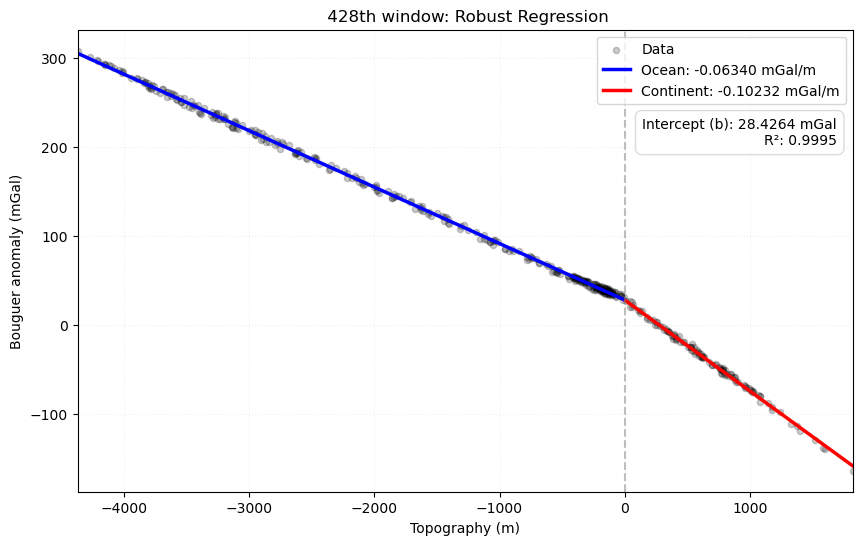

In [14]:
r.plot_window_regression(i_wished_window, h_window, d_window, a_ocean_window, a_continent_window, intercept_window, r2_window)

O círculo rosa é a localização da janela.



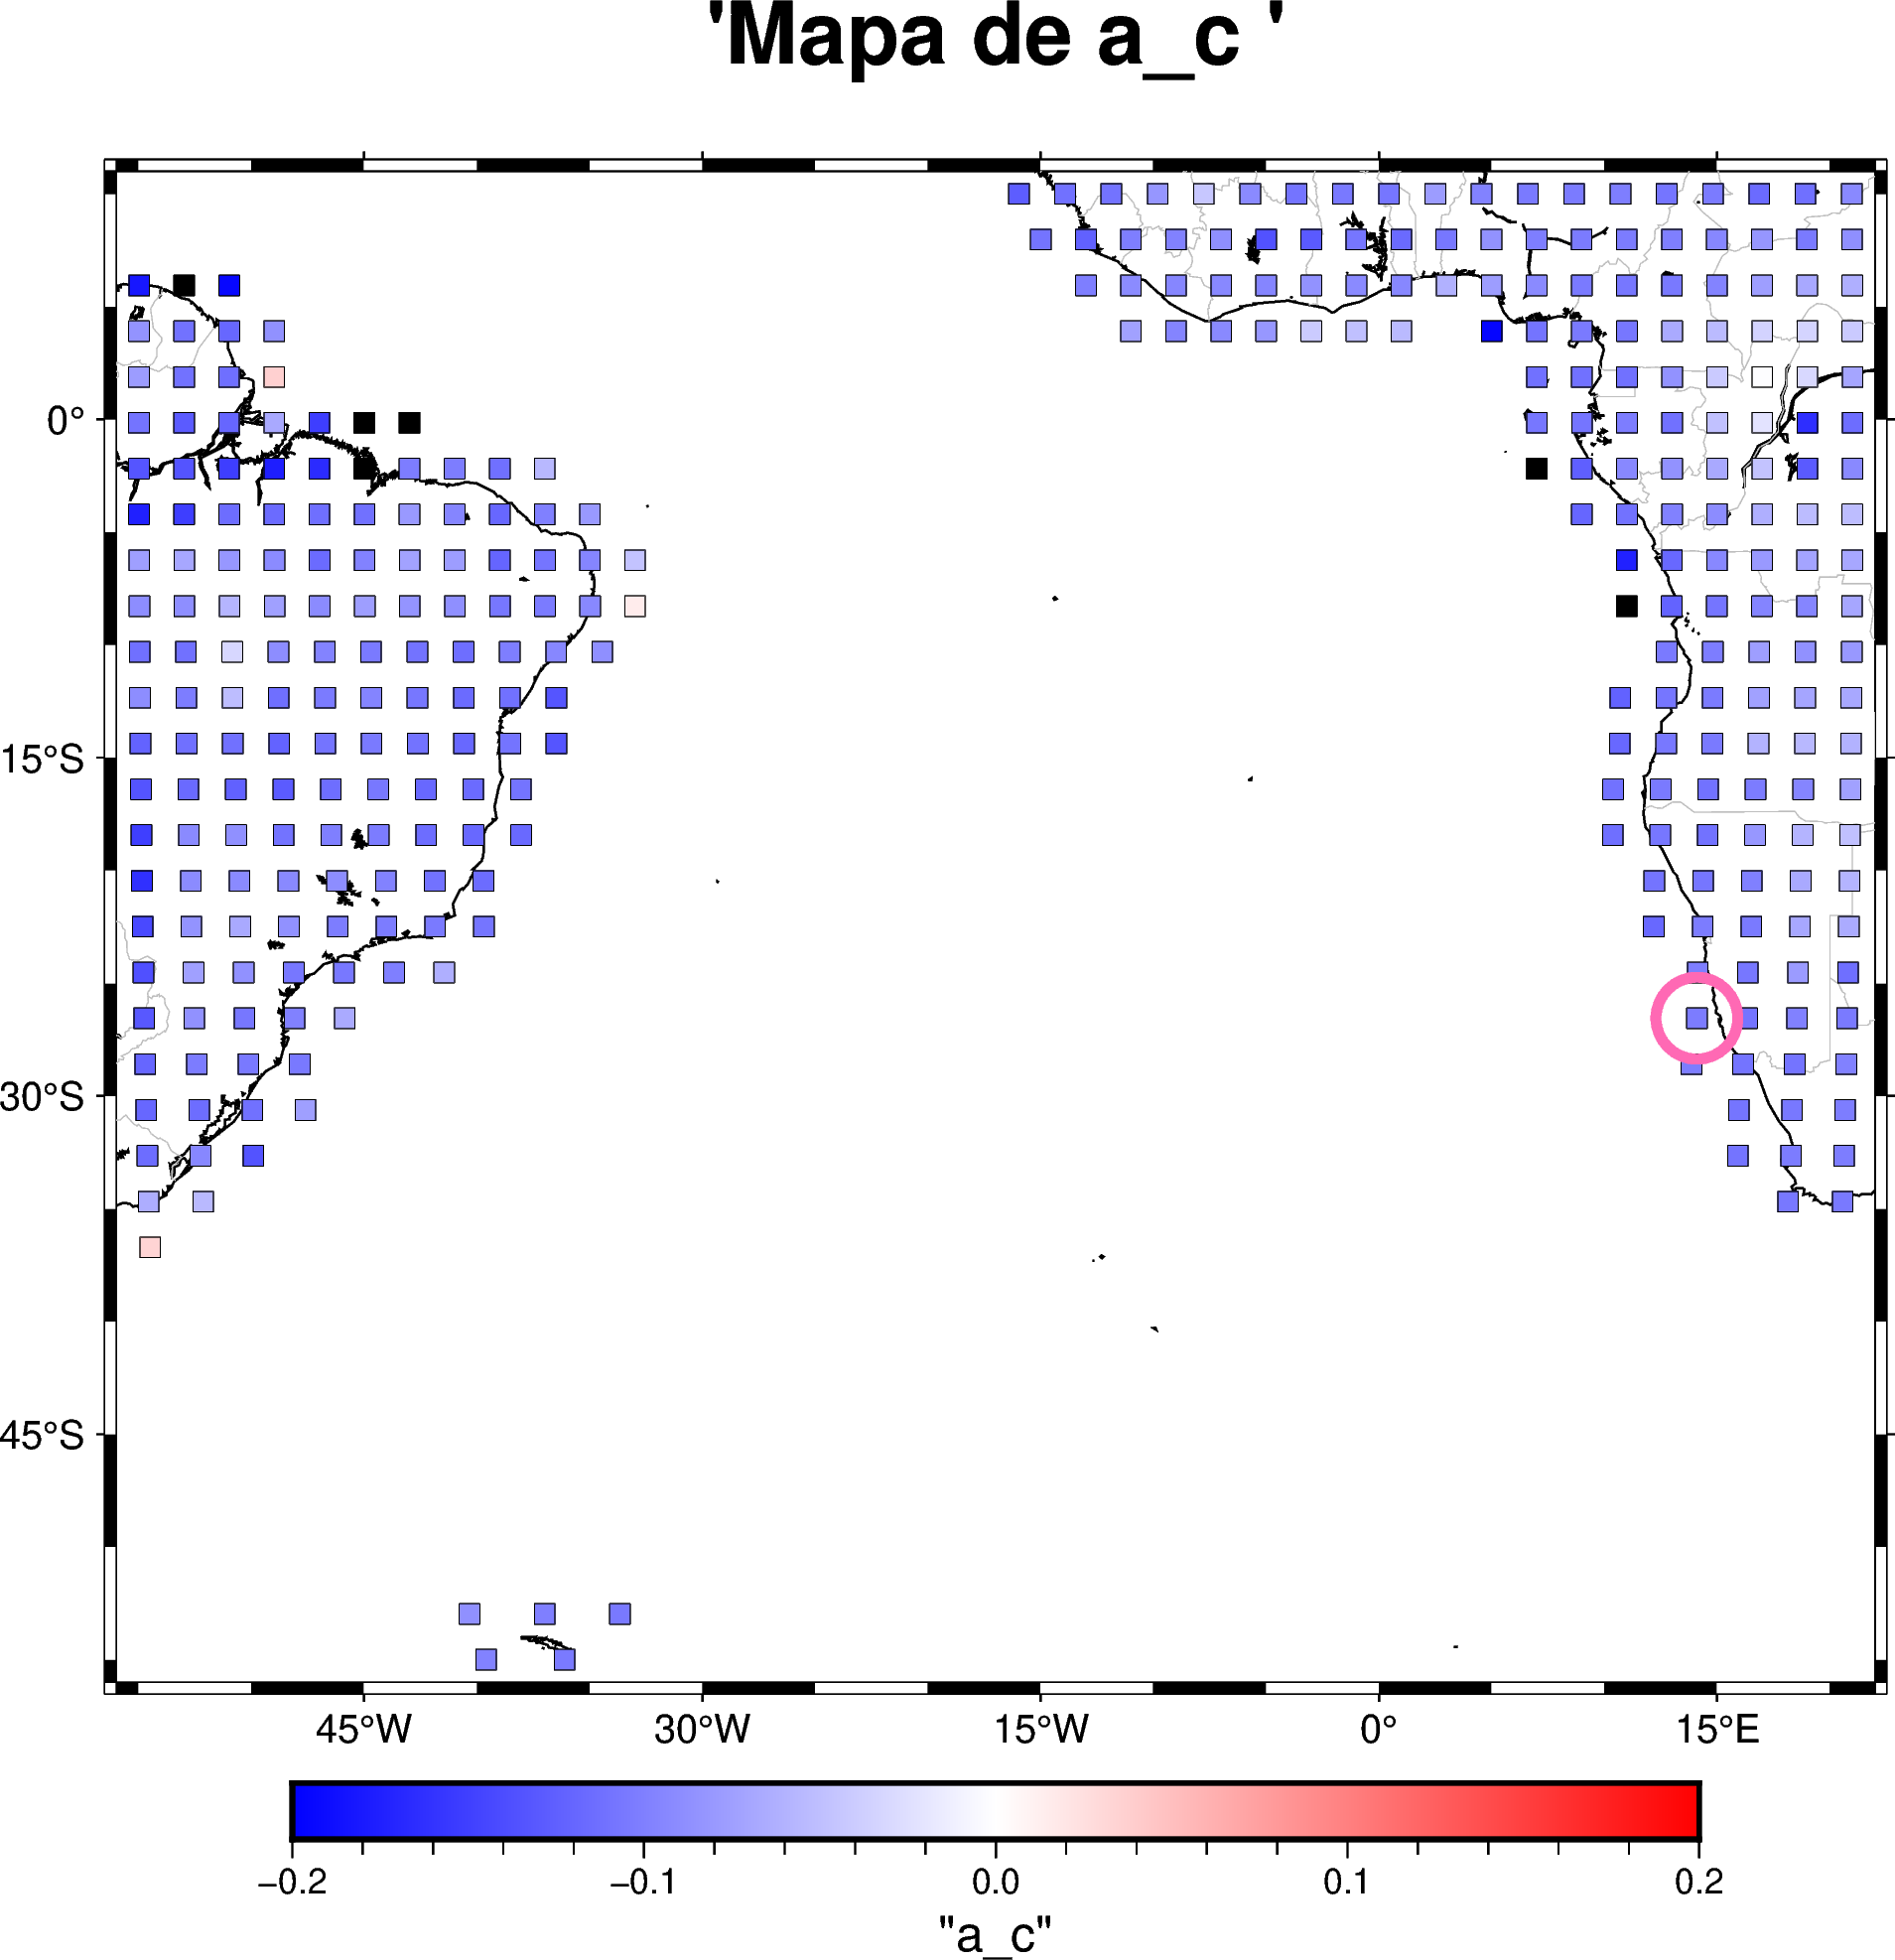

In [15]:

lon_alvo = df_windows.loc[i_wished_window, 'longitude']
lat_alvo = df_windows.loc[i_wished_window, 'latitude']

# 2. Gerar o mapa base (ele retorna o objeto 'fig')
fig = r.plot_parameters_map(df_windows, 'a_c', v_range=[-0.2, 0.2], step=0.01, cmap='polar', reverse=False, projection = 'Q')

# 3. Desenhar um círculo de destaque sobre o mapa
# Criamos um "efeito de borda" com dois círculos sobrepostos
fig.plot(
    x=lon_alvo, 
    y=lat_alvo, 
    style='c0.7c',  # 'c' para circle, 0.7cm de tamanho
    pen='2.5p,hotpink' # Contorno branco grosso
)

print('O círculo rosa é a localização da janela.')
print()
fig.show()


<br>
<br>
<br>
<br>

# Plotando localização de possíveis erros


<br>
<br>
<br>
<br>



<br>
<br>

## R²

<br>
<br>


In [16]:
df_erros_r2 = df_windows[(df_windows.r2 < 0.6)]

df_erros_r2

,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
151,-43.229606,-42.81250,-0.030190,NaN,177.619906,0.238362,151,540,540,0
179,-43.684801,-40.78125,-0.026444,NaN,197.097615,0.112994,179,520,520,0
180,-41.016320,-40.78125,-0.051397,NaN,67.537386,0.454743,180,540,540,0
575,20.891784,-18.43750,NaN,-0.049160,-62.557127,0.479192,575,440,0,440
651,-54.952671,-12.34375,NaN,-0.089183,-21.024350,0.375913,651,420,0,420
653,-50.849680,-12.34375,NaN,-0.051463,-32.039396,0.335857,653,400,0,400
691,-50.862604,-10.31250,NaN,-0.031226,-38.829390,0.156950,691,400,0,400
727,-54.978926,-8.28125,NaN,-0.089176,-24.758781,0.583399,727,400,0,400
728,-52.980035,-8.28125,NaN,-0.089051,-24.121232,0.533248,728,420,0,420
729,-50.981145,-8.28125,NaN,-0.058011,-31.707252,0.433347,729,420,0,420


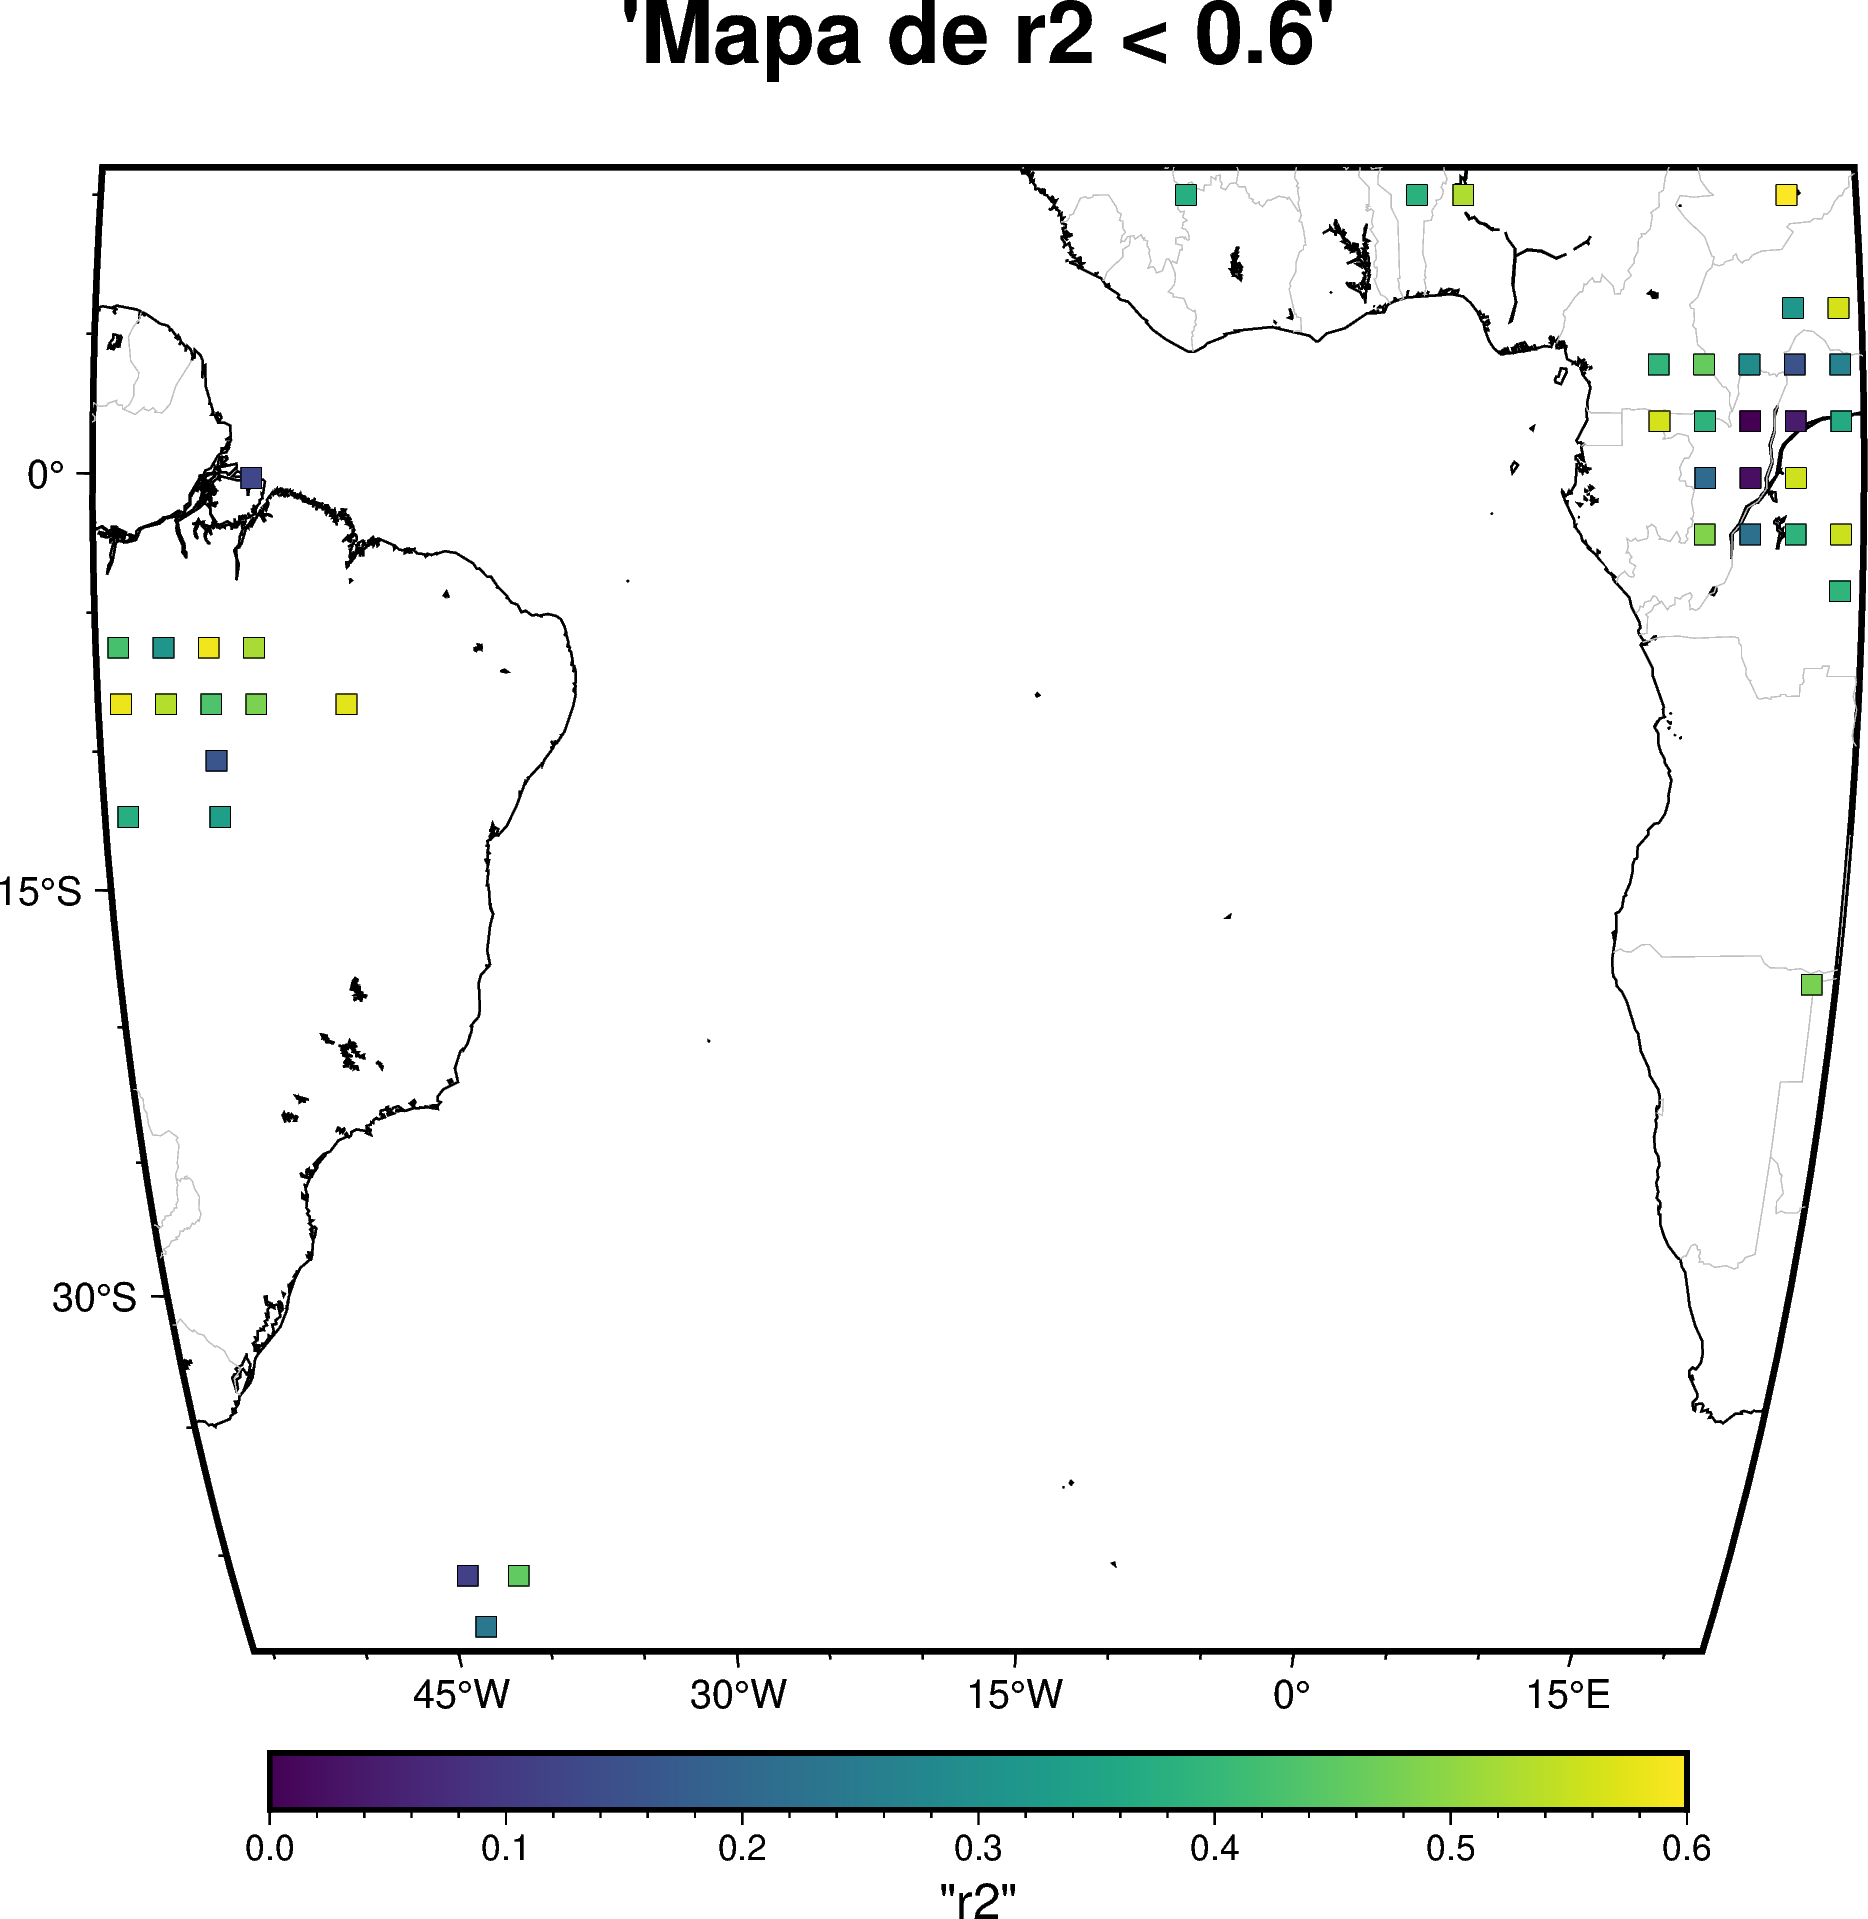

In [17]:
fig_r2_erros = r.plot_parameters_map(df_erros_r2, 'r2', v_range = [0, 0.6], step = 0.01, cmap='viridis', reverse=False, projection = 'W', title_add = '< 0.6')
#fig_r2.coast(shorelines='1p,black')
fig_r2_erros.savefig('mapa-erro-r2.png')


fig_r2_erros.show()

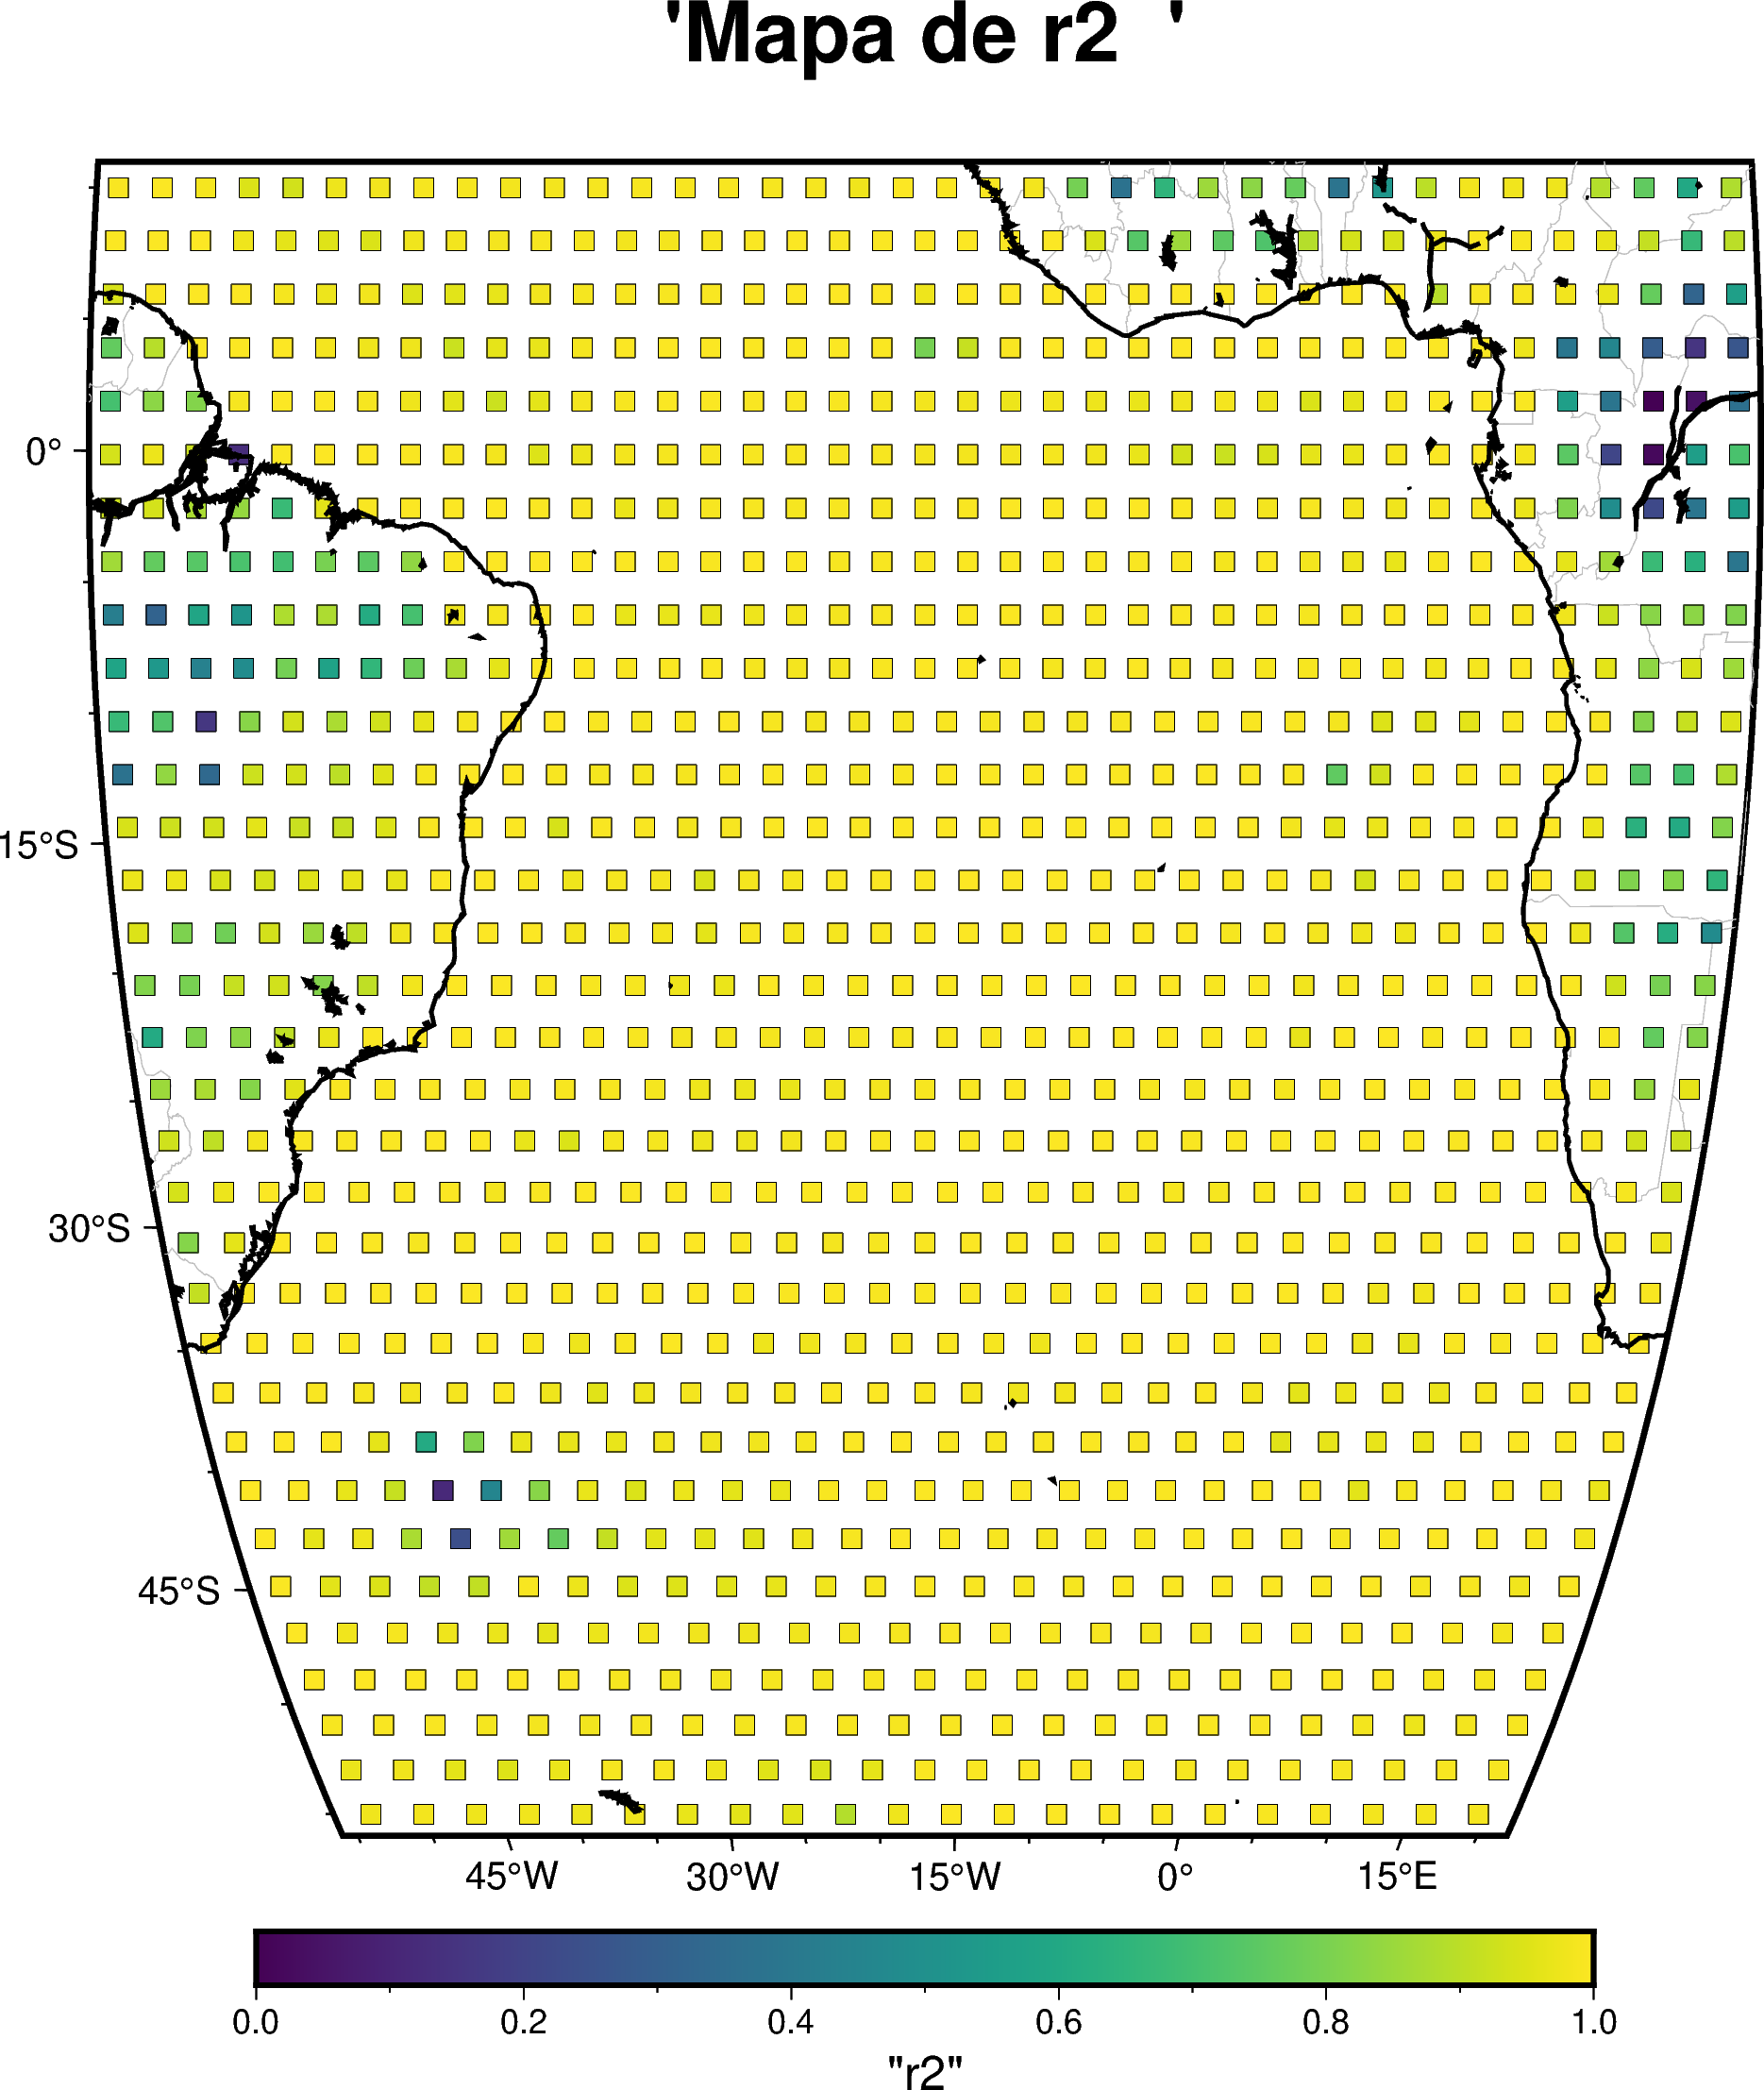

In [18]:
fig_r2 = r.plot_parameters_map(df_windows, 'r2', v_range = [0, 1], step = 0.01, cmap='viridis', reverse=False, projection = 'W', title_add = " ")
fig_r2.coast(shorelines='1p,black')
fig_r2.savefig('mapa-r2.png')

fig_r2.show()



<br>
<br>

## a_o

<br>
<br>




In [19]:
df_erros_oceano = df_windows[(df_windows.ocean_points > 0) & (df_windows.a_o.isna())]
df_erros_oceano

,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
330,-54.675823,-30.62500,NaN,-0.119300,14.885702,0.817958,330,480,3,477
545,-42.261189,-18.43750,NaN,-0.114538,-6.300818,0.978918,545,420,1,419
845,-52.998618,-2.18750,NaN,-0.134396,-14.161664,0.935060,845,420,3,417
878,12.998849,-2.18750,NaN,-0.085118,-12.586570,0.807565,878,420,3,417
1033,10.992052,5.93750,NaN,-0.106865,17.031457,0.990702,1033,420,2,418
1066,-1.008211,7.96875,NaN,-0.107837,14.804517,0.723439,1066,420,1,419


In [20]:
# transformando em 0 para o gmt plotar
df_erros_oceano.loc[(df_erros_oceano.ocean_points > 0 & df_erros_oceano.a_o.isna()), 'a_o'] = 0
df_erros_oceano

,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
330,-54.675823,-30.62500,0.0,-0.119300,14.885702,0.817958,330,480,3,477
545,-42.261189,-18.43750,0.0,-0.114538,-6.300818,0.978918,545,420,1,419
845,-52.998618,-2.18750,0.0,-0.134396,-14.161664,0.935060,845,420,3,417
878,12.998849,-2.18750,0.0,-0.085118,-12.586570,0.807565,878,420,3,417
1033,10.992052,5.93750,0.0,-0.106865,17.031457,0.990702,1033,420,2,418
1066,-1.008211,7.96875,0.0,-0.107837,14.804517,0.723439,1066,420,1,419


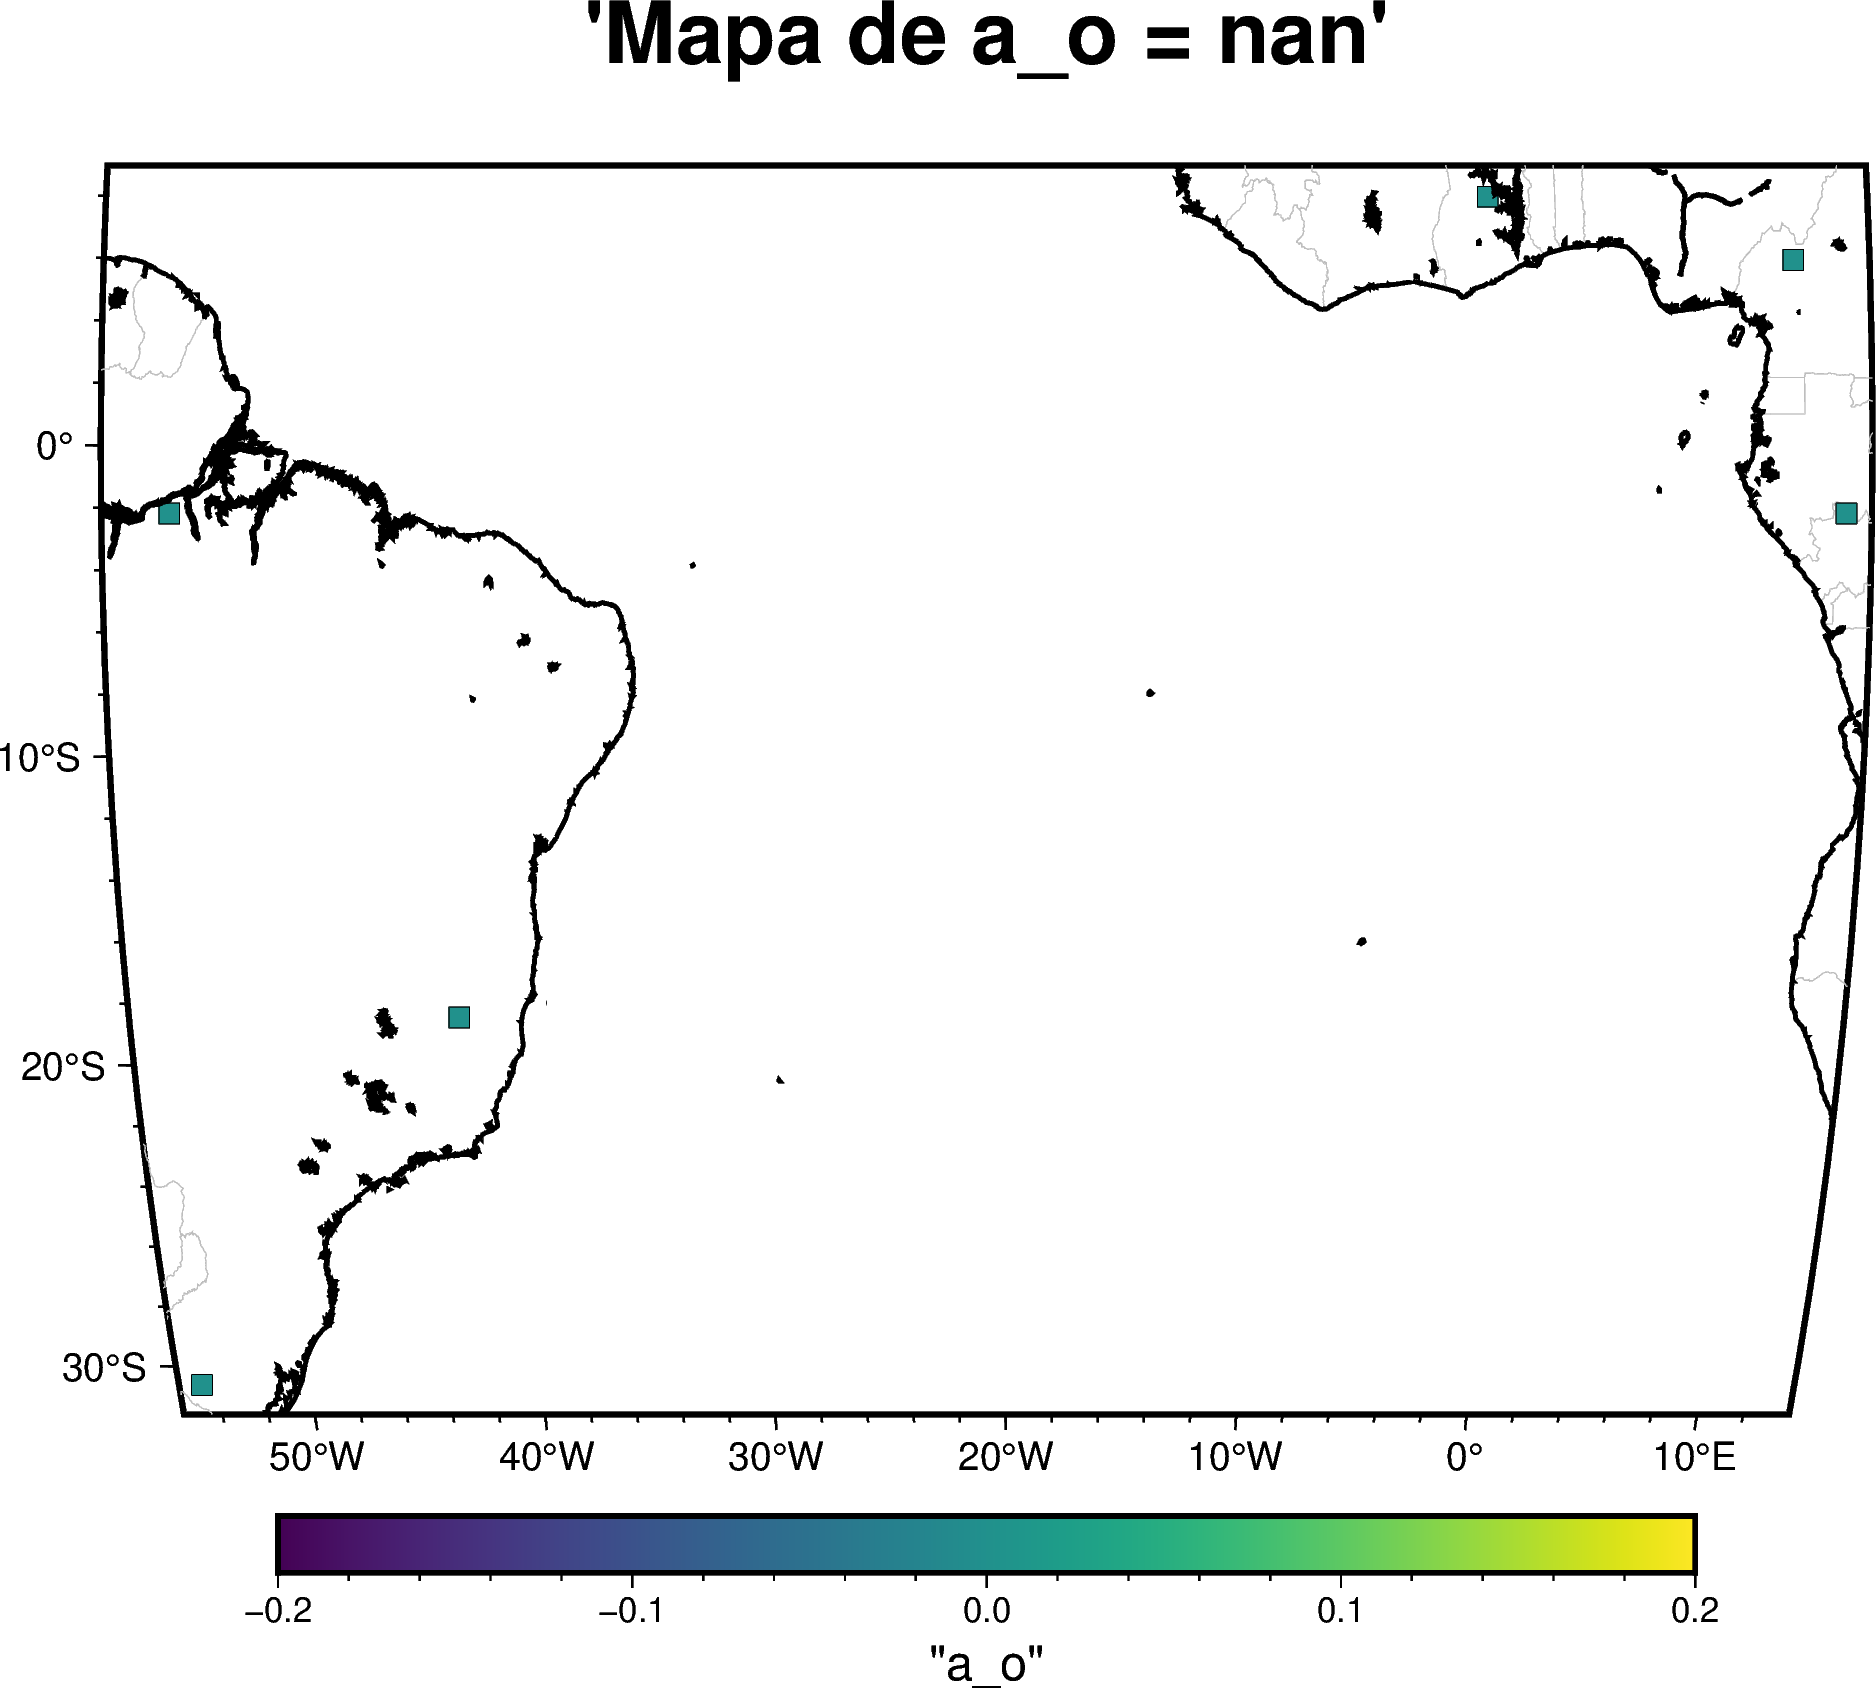

In [21]:
fig_cont_erros = r.plot_parameters_map(df_erros_oceano, 'a_o', v_range = [-0.2, 0.2], step = 0.01, cmap='viridis', reverse=False, projection = 'W', title_add = '= nan')
fig_cont_erros.coast(shorelines='1p,black')
fig_cont_erros.savefig('mapa-erro-a_o.png')

fig_cont_erros.show()


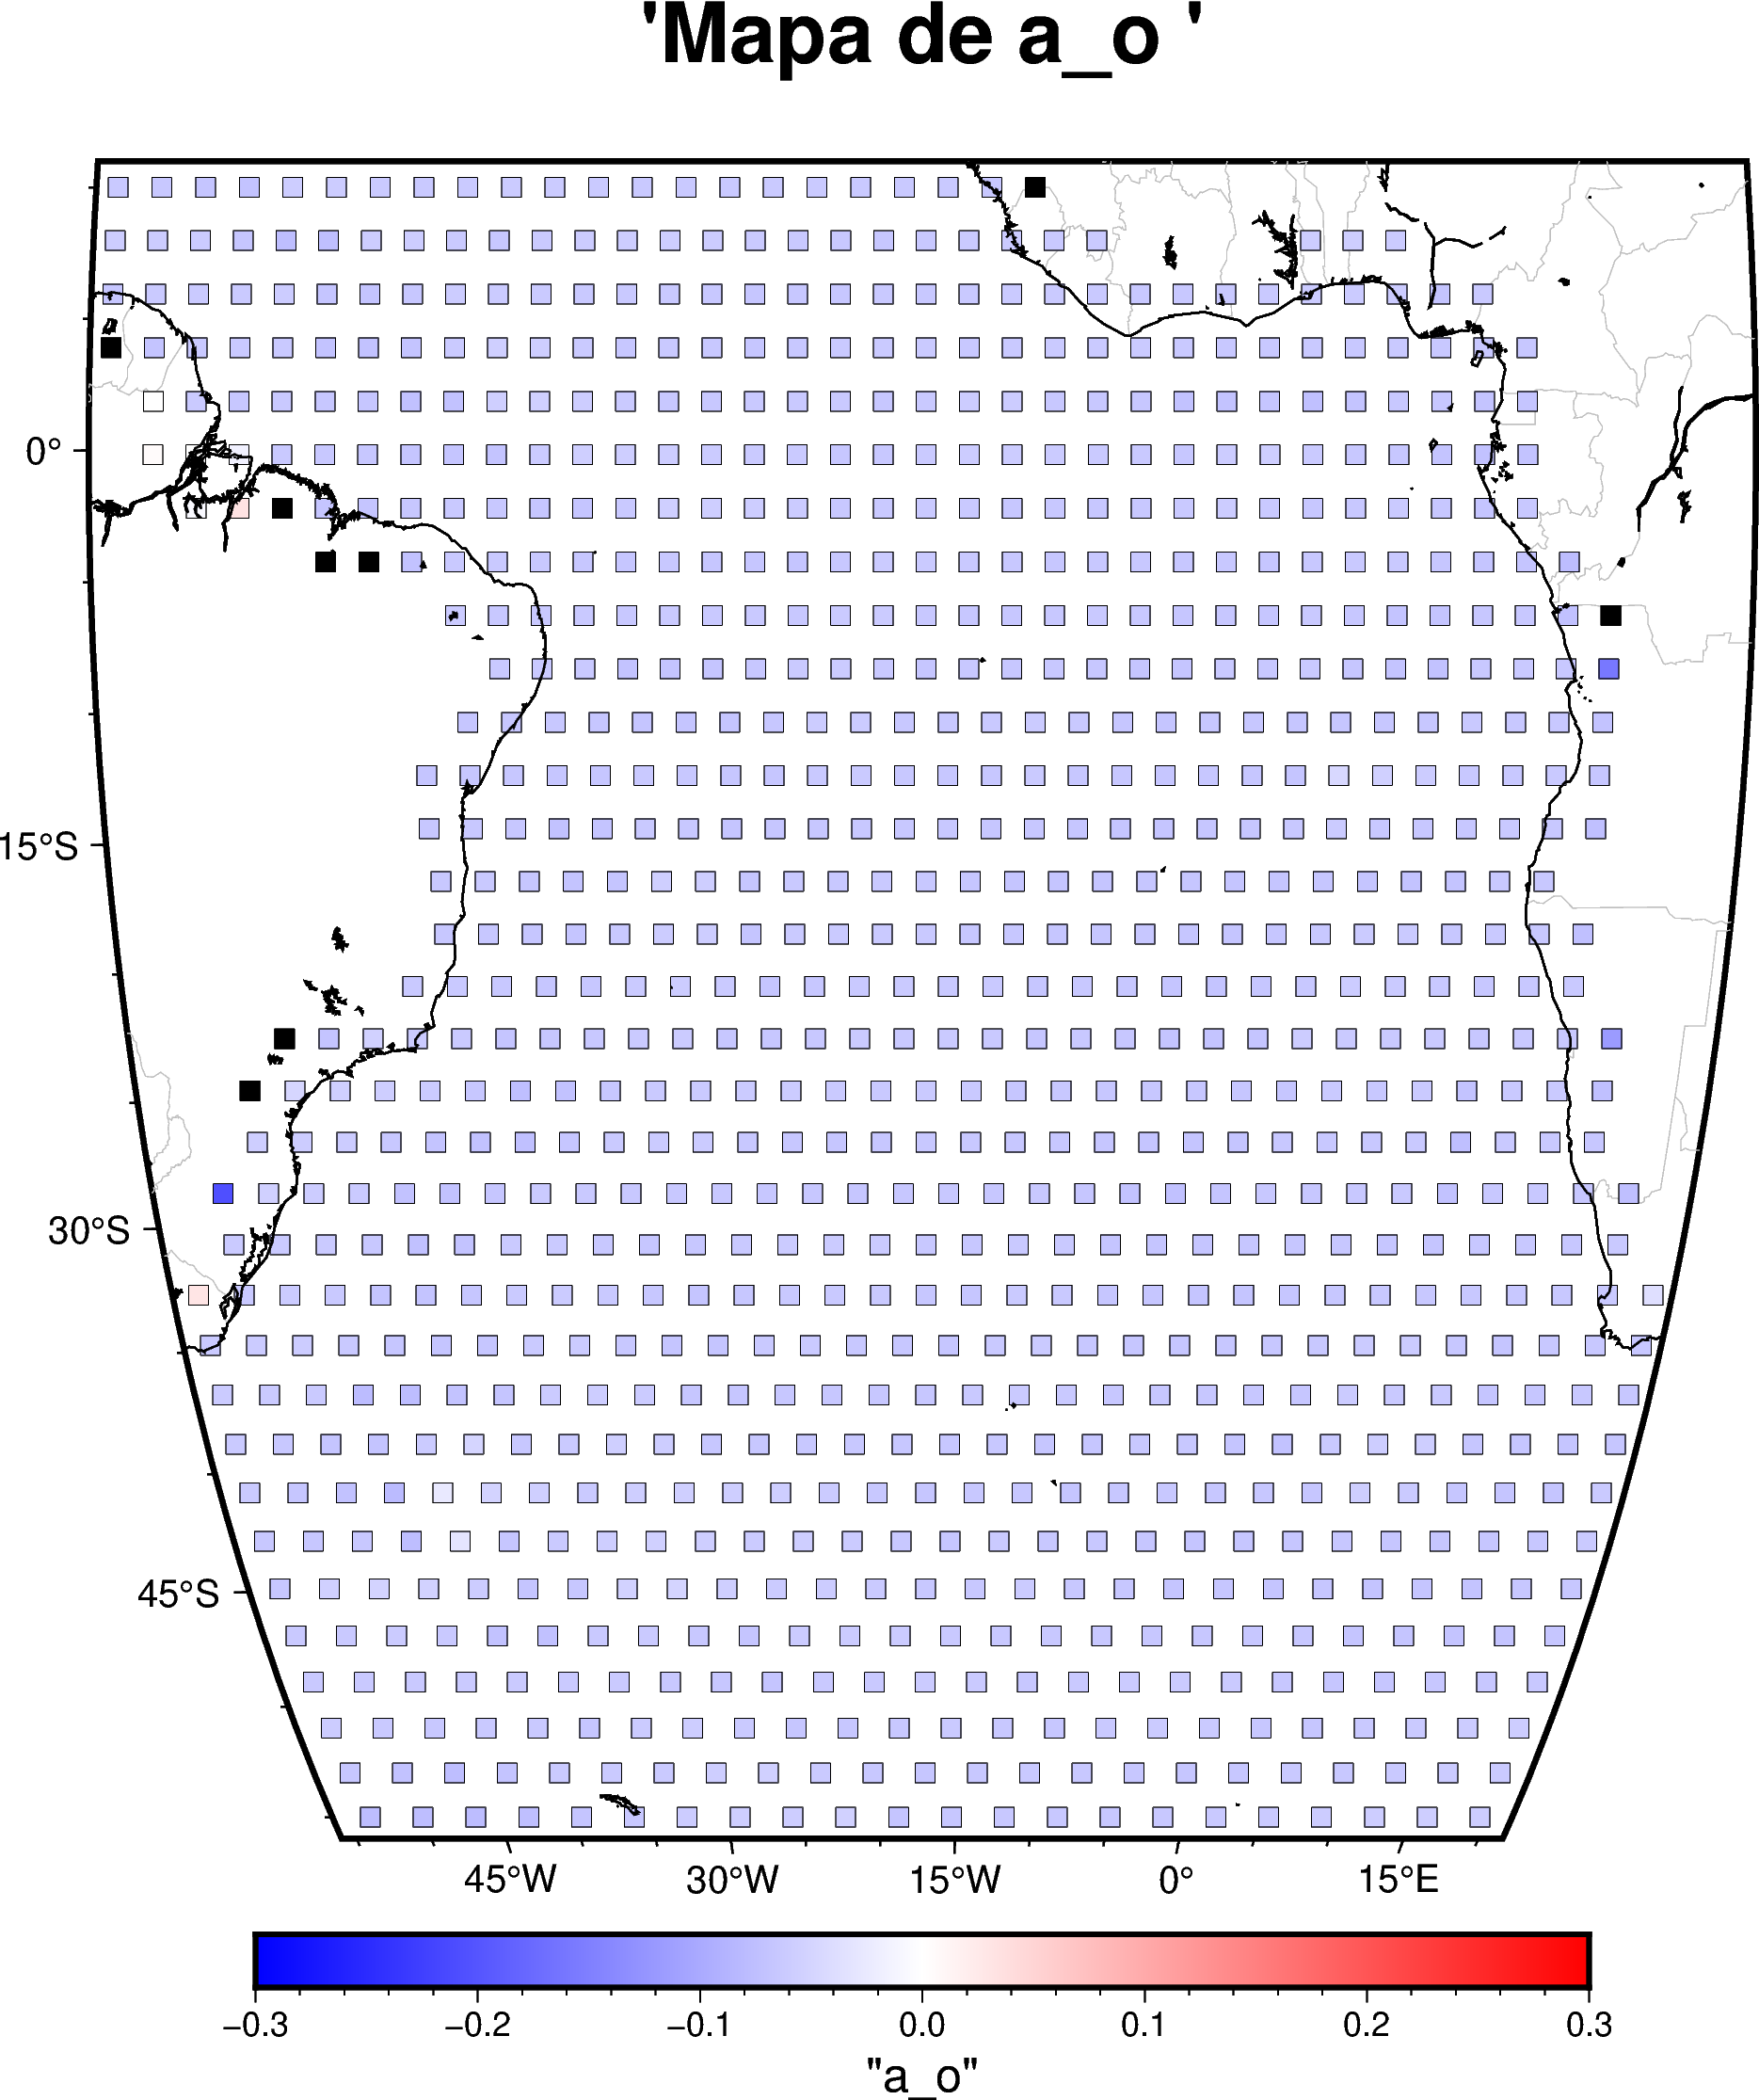

In [22]:
fig_a_o = r.plot_parameters_map(df_windows, 'a_o', v_range = [-0.3, 0.3], step = 0.01, cmap = 'polar', reverse = False, projection = 'W')
fig_a_o.coast(shorelines = '0.5p,black')
fig_a_o.savefig('mapa-a_o.png')

fig_a_o.show()

In [23]:
# valores fora da escala
df_ac_out_escale = df_windows[(df_windows.a_o.notna()) & ((df_windows.a_o < -0.3) | (df_windows.a_o > 0.3))]
df_ac_out_escale

,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
434,-50.354315,-24.53125,-0.956884,-0.086170,-17.906993,0.818545,434,440,11,429
470,-48.349179,-22.50000,-1.087096,-0.086667,-25.057982,0.904397,470,440,7,433
801,14.989930,-6.25000,-0.380919,-0.093671,-11.114256,0.920534,801,420,4,416
810,-44.995996,-4.21875,-1.938033,-0.111536,-32.697026,0.796425,810,420,6,414
811,-42.996282,-4.21875,-0.862679,-0.079824,-28.570439,0.748806,811,420,30,390
848,-46.998849,-2.18750,-0.435569,-0.165922,-20.612571,0.677559,848,420,84,336
885,-50.999993,-0.15625,0.369568,-0.119951,-13.295911,0.923651,885,420,64,356
923,-52.998985,1.87500,2.442204,-0.110113,-19.911777,0.828299,923,420,5,415
961,-54.995343,3.90625,-0.842767,-0.085093,-29.288167,0.760349,961,400,9,391
1099,-11.869034,10.00000,-0.534668,-0.110057,28.477625,0.983500,1099,420,29,391


In [24]:
# df_ac_out_escale.loc[:, 'a_o'] = 0 # todos pontos fora de escala transformei em coeficiente 0 para o plot

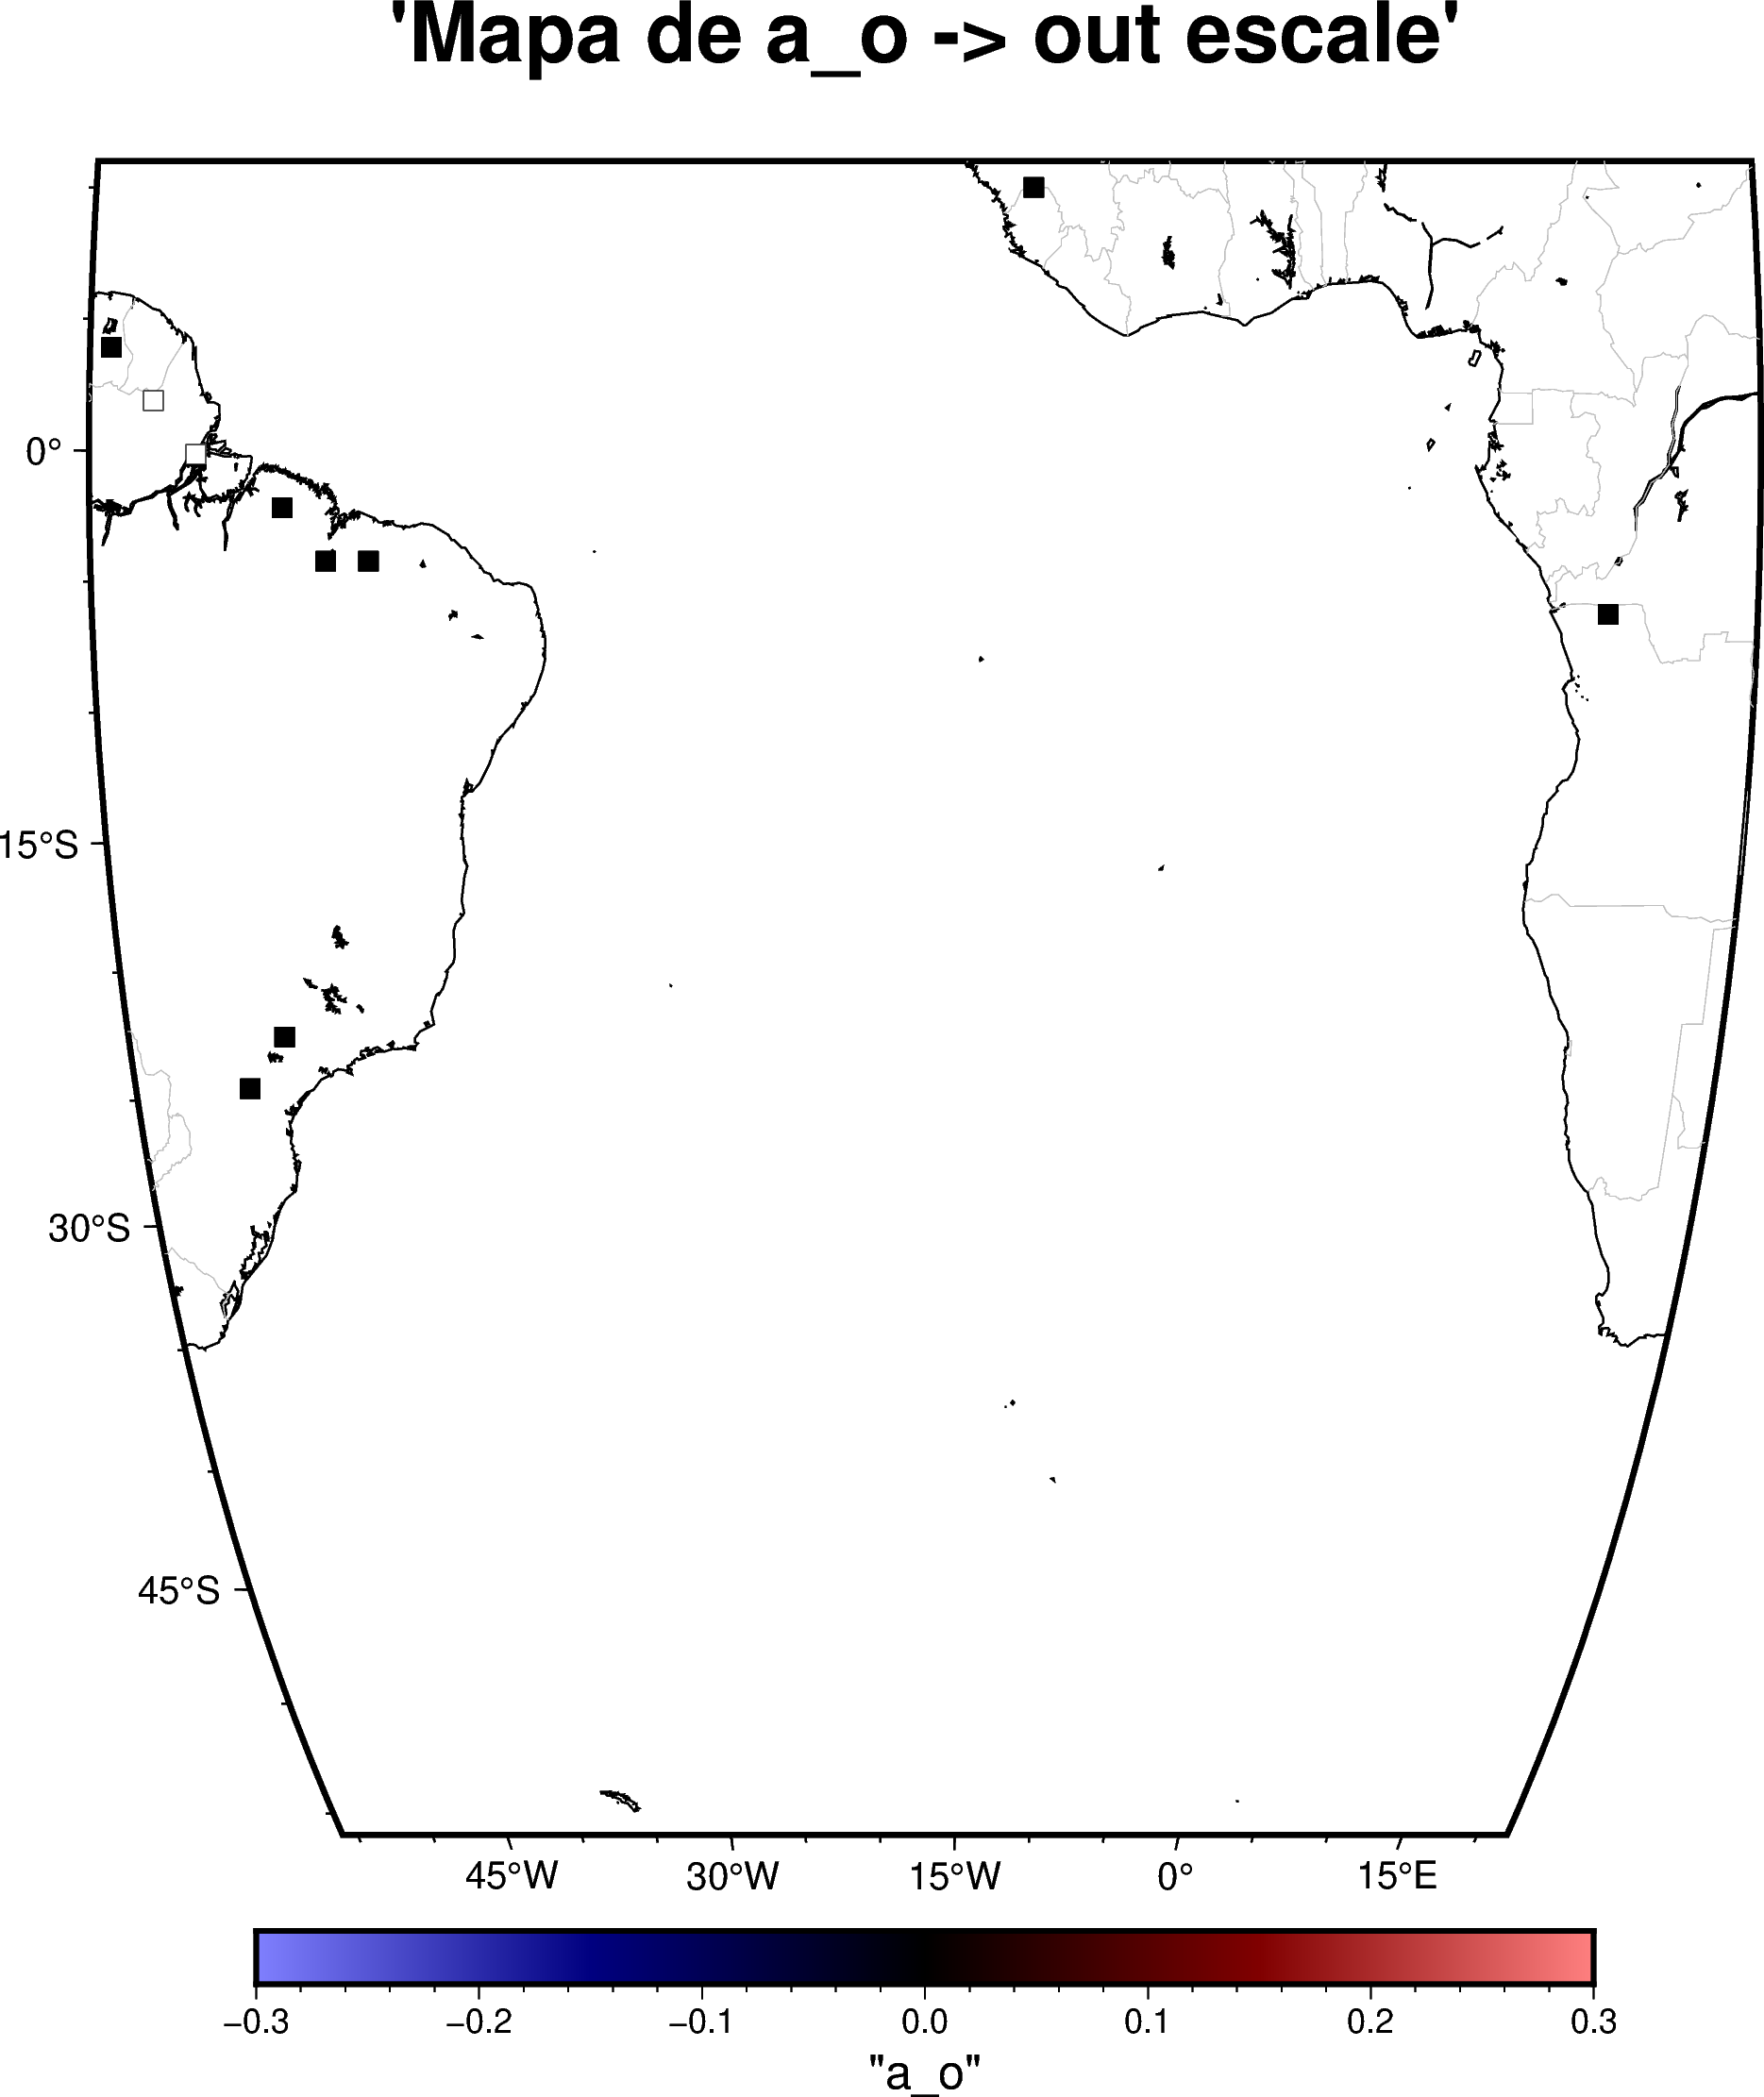

In [25]:
fig_ac_out_escale = r.plot_parameters_map(df_ac_out_escale, 'a_o', v_range = [-0.3, 0.3], step = 0.01, cmap = 'split', reverse = False, projection = 'W',
    title_add = '-> out escale', ref_data = df_windows,
    #plot_coast = False
) 
fig_ac_out_escale.savefig('mapa-a_o-out-escale.png')
fig_ac_out_escale.show()


<br>
<br>

## a_c

<br>
<br>



In [26]:
df_erros_continente = df_windows[(df_windows.continent_points > 0) & (df_windows.a_c.isna())]
df_erros_continente

,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
6,-32.648474,-55.00000,-0.060061,NaN,40.784174,0.967737,6,735,732,3
16,2.125913,-55.00000,-0.063706,NaN,32.224609,0.995649,16,735,734,1
17,5.603352,-55.00000,-0.061685,NaN,35.707112,0.992307,17,735,734,1
39,3.006794,-52.96875,-0.065285,NaN,26.107169,0.992026,39,660,659,1
40,6.341260,-52.96875,-0.063693,NaN,29.426456,0.992869,40,660,659,1
139,0.159656,-44.84375,-0.067108,NaN,7.853284,0.997136,139,560,559,1
140,3.019599,-44.84375,-0.067877,NaN,2.994773,0.998384,140,580,579,1
167,0.946572,-42.81250,-0.067631,NaN,3.857268,0.999004,167,540,539,1
168,3.707584,-42.81250,-0.067464,NaN,5.081920,0.998176,168,560,559,1
204,-54.435518,-38.75000,-0.062160,NaN,14.085773,0.999243,204,500,498,2


In [27]:
# transformando em 0 para o gmt plotar
df_erros_continente.loc[(df_erros_continente.continent_points > 0 & df_erros_continente.a_c.isna()), 'a_c'] = 0
df_erros_continente

,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
6,-32.648474,-55.00000,-0.060061,0.0,40.784174,0.967737,6,735,732,3
16,2.125913,-55.00000,-0.063706,0.0,32.224609,0.995649,16,735,734,1
17,5.603352,-55.00000,-0.061685,0.0,35.707112,0.992307,17,735,734,1
39,3.006794,-52.96875,-0.065285,0.0,26.107169,0.992026,39,660,659,1
40,6.341260,-52.96875,-0.063693,0.0,29.426456,0.992869,40,660,659,1
139,0.159656,-44.84375,-0.067108,0.0,7.853284,0.997136,139,560,559,1
140,3.019599,-44.84375,-0.067877,0.0,2.994773,0.998384,140,580,579,1
167,0.946572,-42.81250,-0.067631,0.0,3.857268,0.999004,167,540,539,1
168,3.707584,-42.81250,-0.067464,0.0,5.081920,0.998176,168,560,559,1
204,-54.435518,-38.75000,-0.062160,0.0,14.085773,0.999243,204,500,498,2


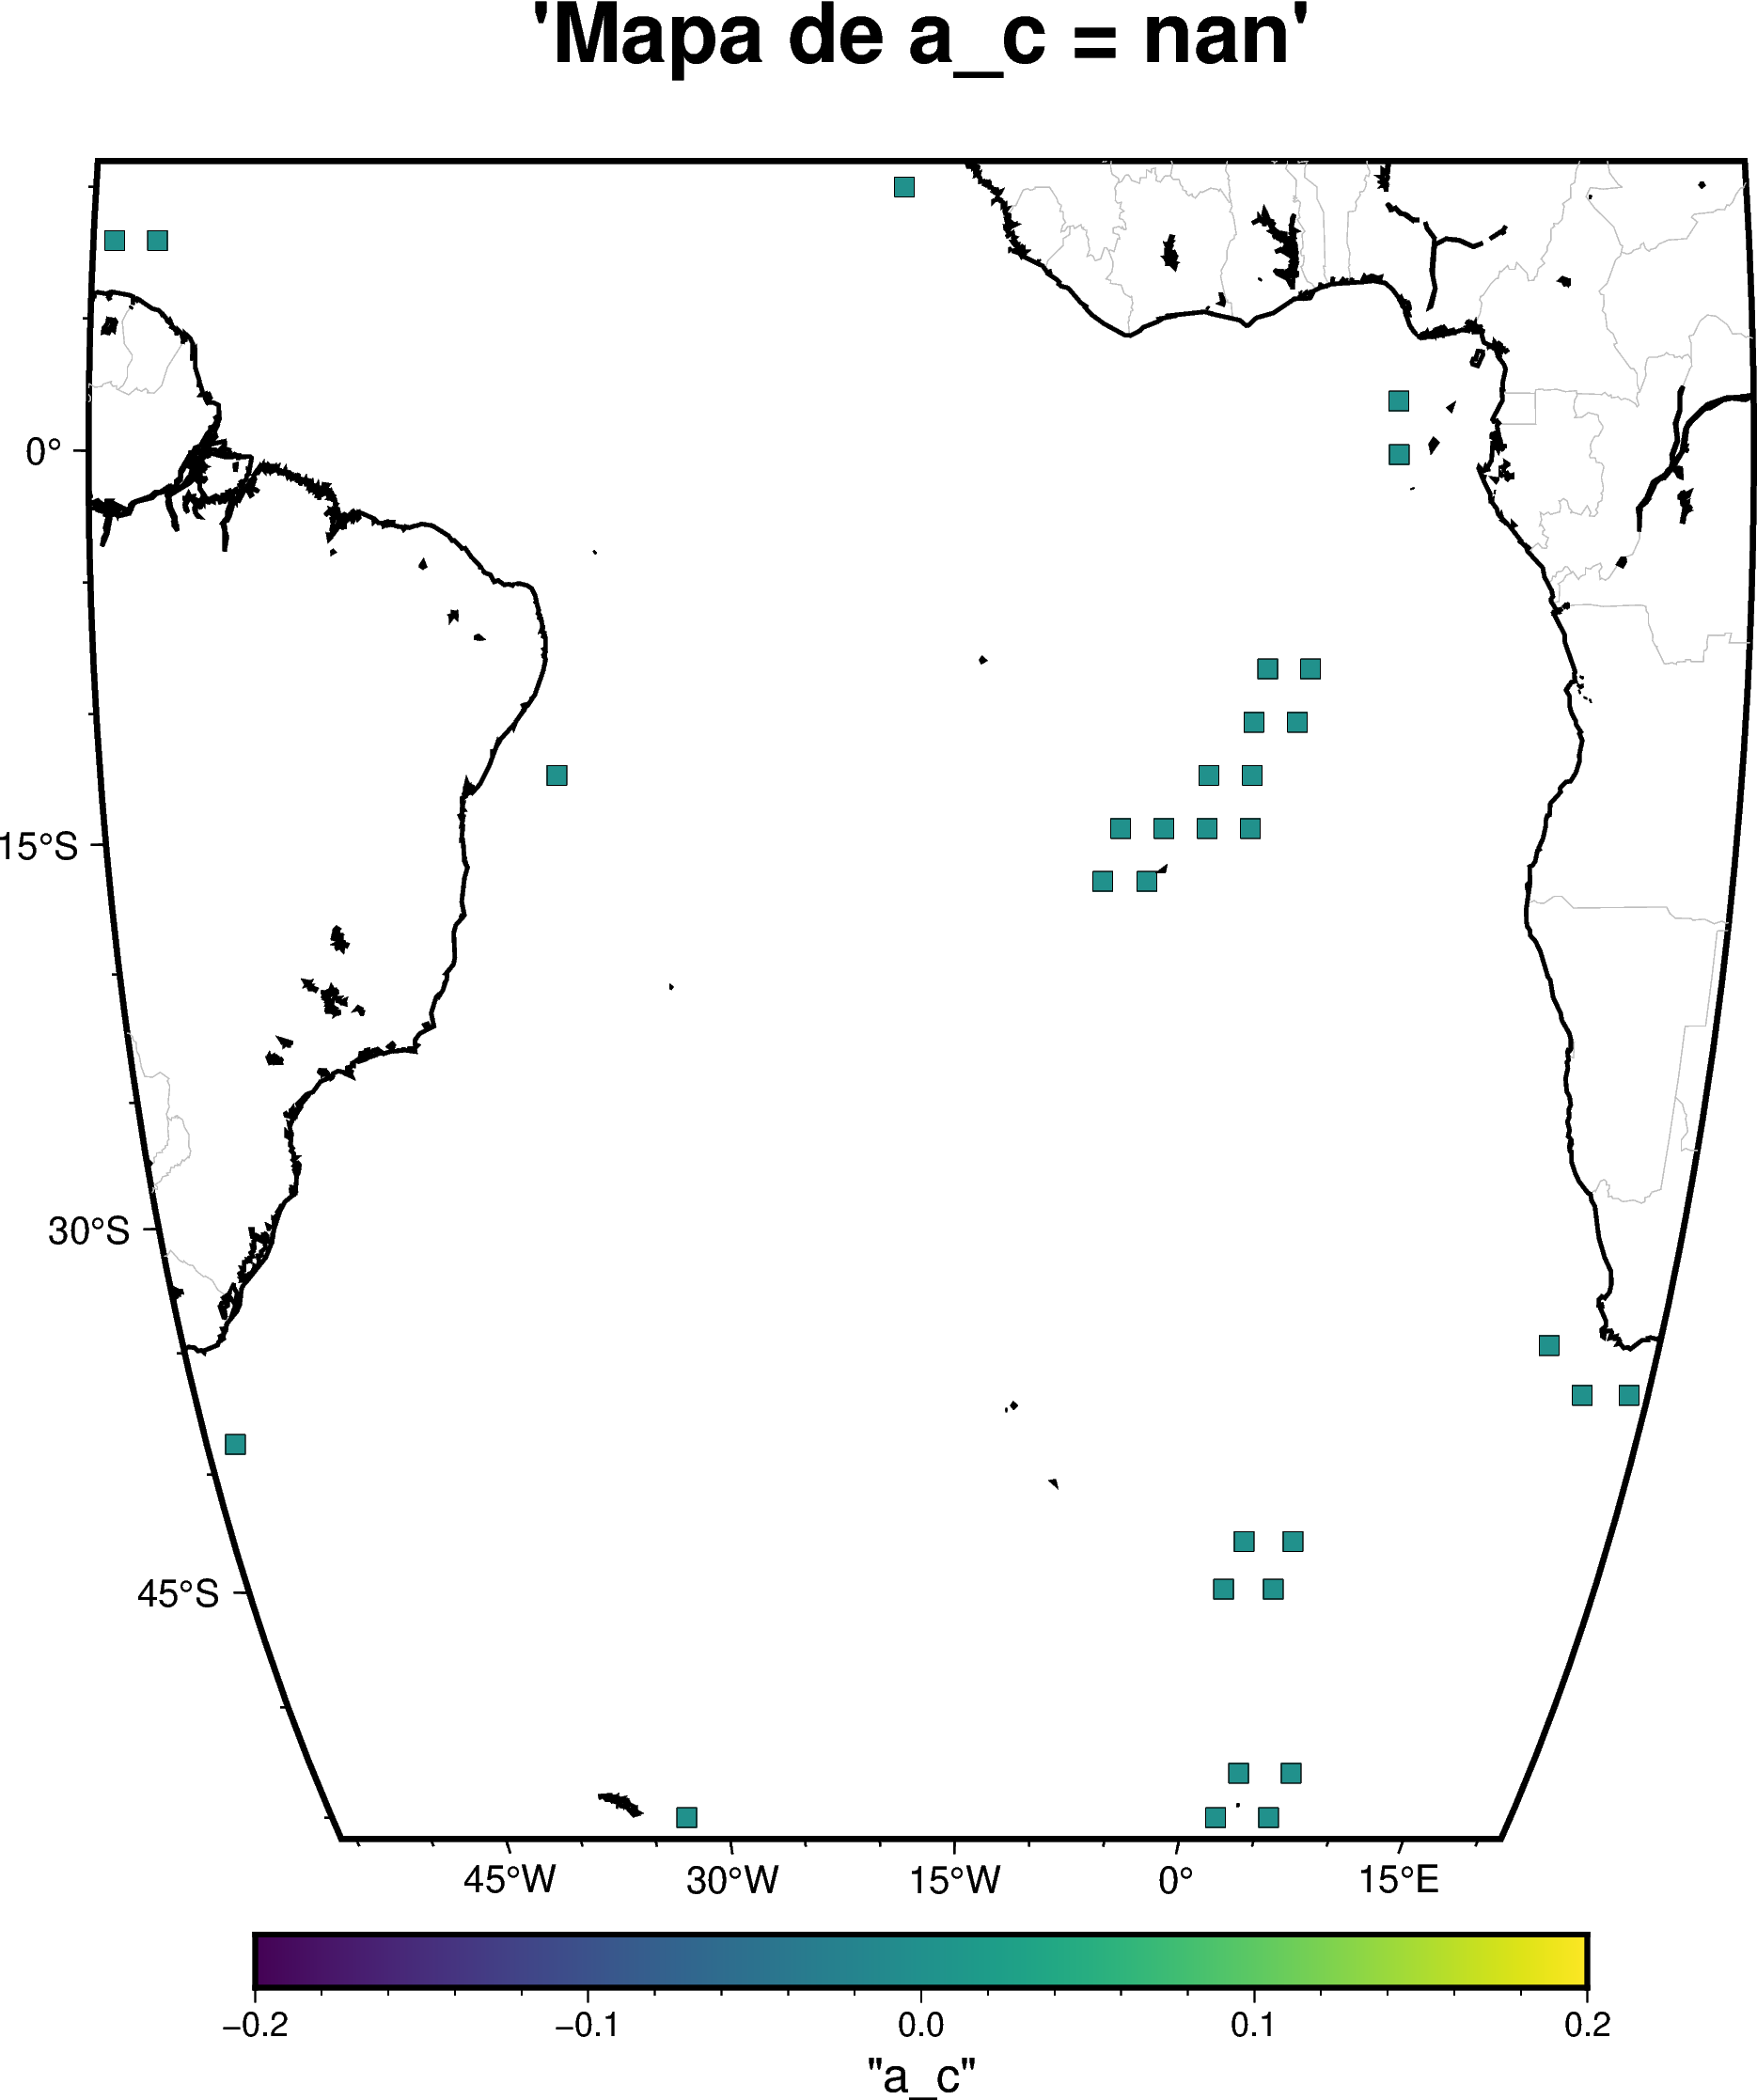

In [28]:
fig_cont_erros = r.plot_parameters_map(df_erros_continente, 'a_c', v_range = [-0.2, 0.2], step = 0.01, cmap='viridis', reverse=False, projection = 'W', title_add = '= nan')
fig_cont_erros.coast(shorelines='1p,black')
fig_cont_erros.savefig('mapa-erro-a_c.png')

fig_cont_erros.show()


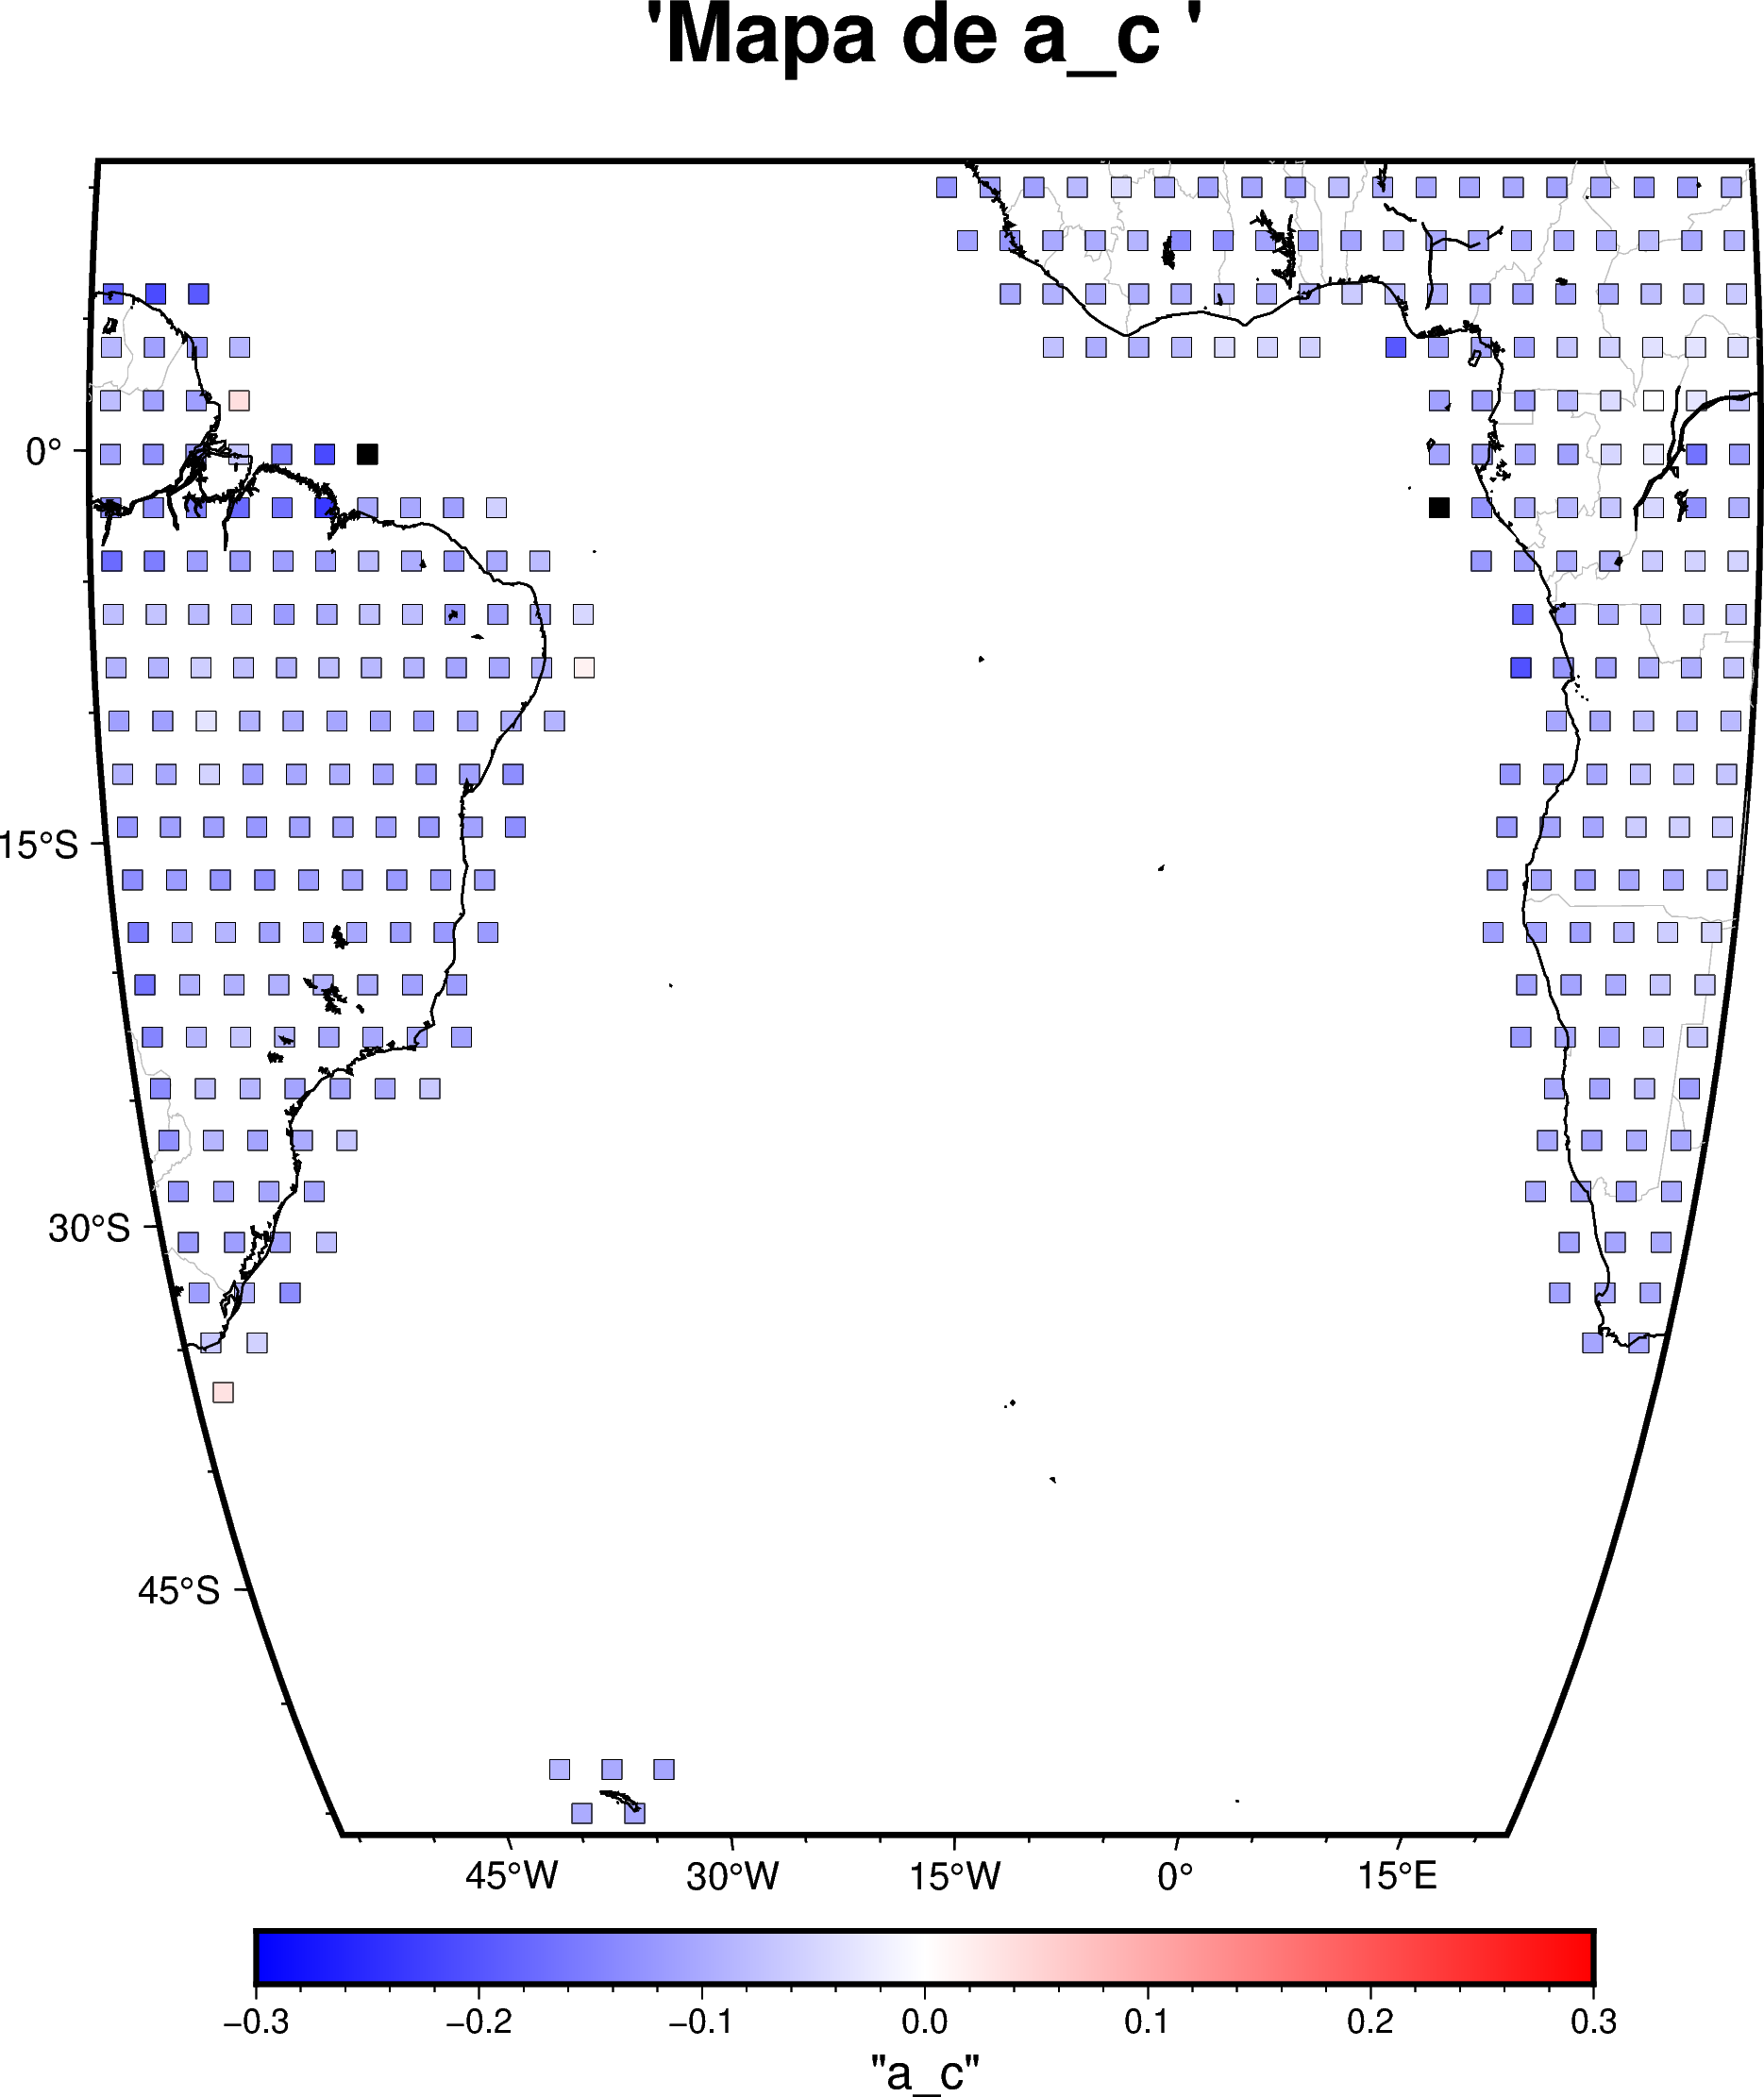

In [29]:
fig_a_c = r.plot_parameters_map(df_windows, 'a_c', v_range = [-0.3, 0.3], step = 0.01, cmap = 'polar', reverse = False, projection = 'W',
    #plot_coast = False
)
fig_a_c.coast(shorelines = '0.5p,black')
fig_a_c.savefig('mapa-a_c.png')

fig_a_c.show()

In [30]:
# valores fora da escala
df_ac_out_escale = df_windows[(df_windows.a_c.notna()) & ((df_windows.a_c < -0.3) | (df_windows.a_c > 0.3))]
df_ac_out_escale

,longitude,latitude,a_o,a_c,b,r2,original-idx,total_points,ocean_points,continent_points
875,6.999079,-2.18750,-0.065406,-0.471082,11.799468,0.987775,875,420,416,4
889,-42.999995,-0.15625,-0.065482,-0.400432,-12.508923,0.998624,889,420,411,9


In [31]:
# df_ac_out_escale.loc[:, 'a_c'] = 0 # todos pontos fora de escala transformei em coeficiente 0 para o plot

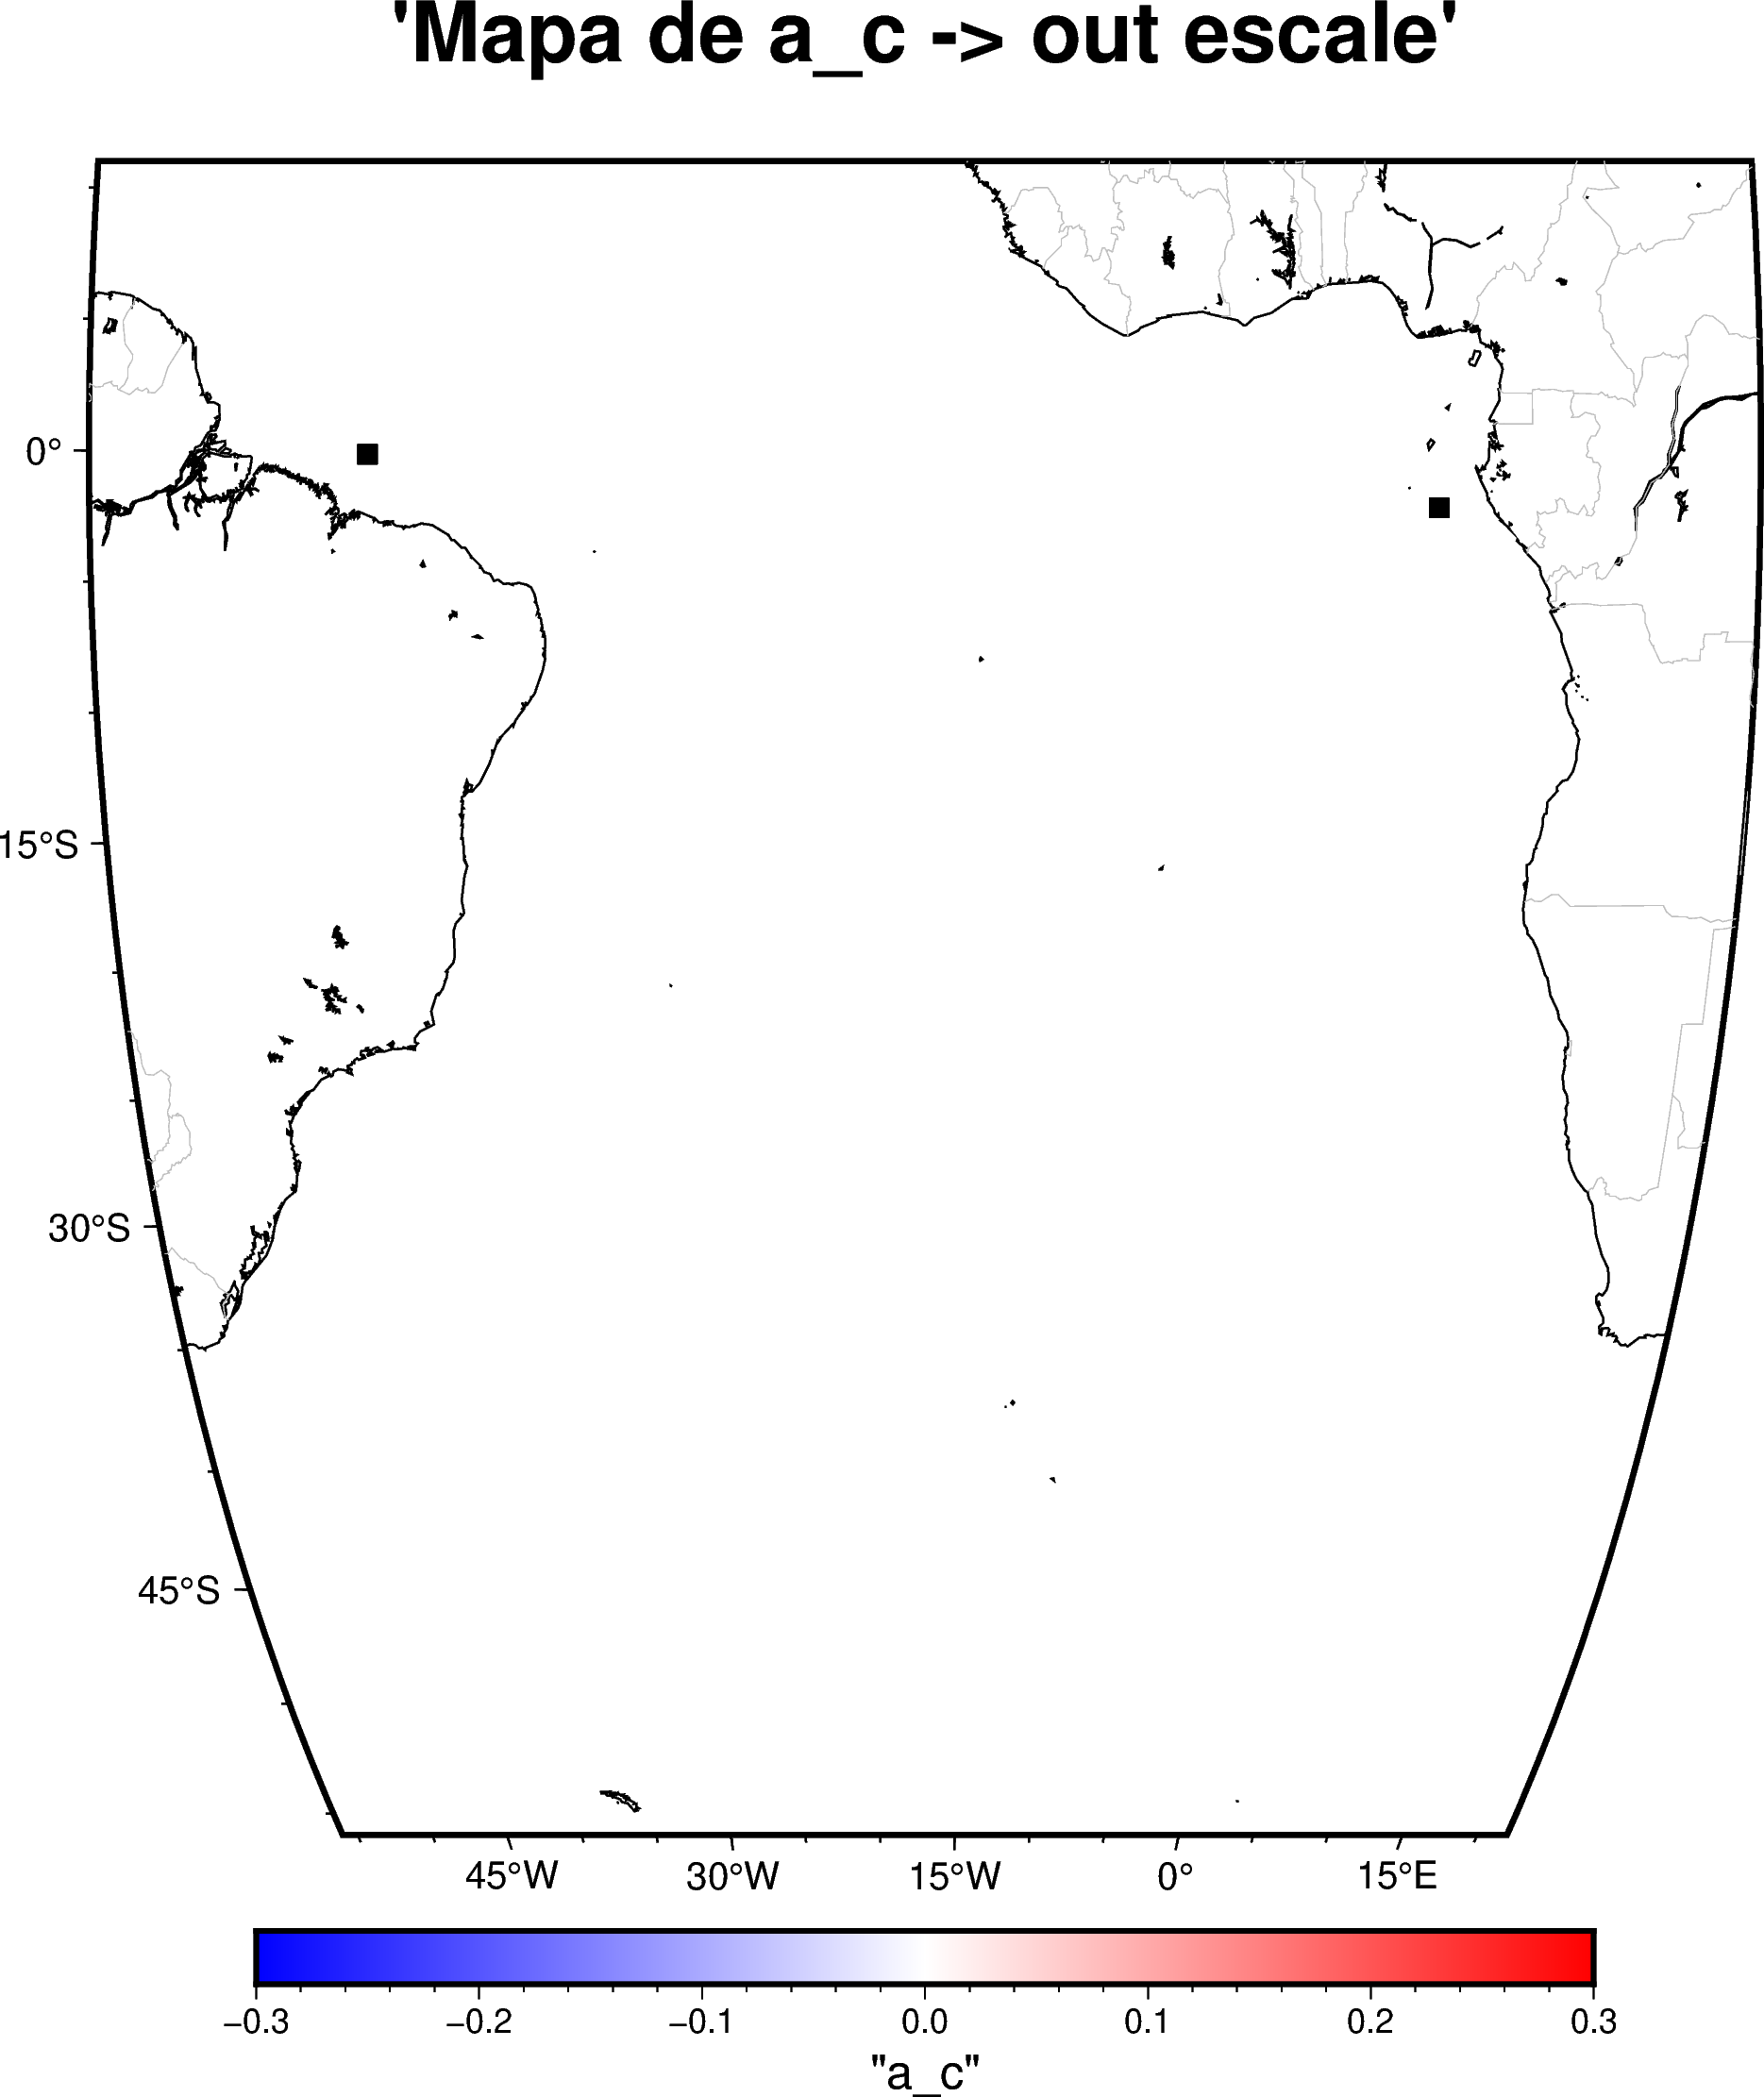

In [32]:
fig_ac_out_escale = r.plot_parameters_map(df_ac_out_escale, 'a_c', v_range = [-0.3, 0.3], step = 0.01, cmap = 'polar', reverse = False, projection = 'W',
    title_add = '-> out escale', ref_data = df_windows,
    #plot_coast = False
) 
#fig_a_c.coast(shorelines = '0.5p,black')
fig_ac_out_escale.savefig('mapa-a_c-out-escale.png')

fig_ac_out_escale.show()